<a href="https://colab.research.google.com/github/niktart/AntiplagiarismHSE/blob/main/final_term_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных

In [ ]:
import pandas as pd
import json
from pathlib import Path
import numpy as np


### Загружаю датасеты, у которых есть только папка train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_file_path = '/content/drive/MyDrive/term_work/vegetable.v1i.yolov8.zip'
extraction_path = '/content/vegetable_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extraction complete. Data extracted to {extraction_path}.")

Extraction complete. Data extracted to /content/vegetable_data.


In [ ]:
zip_file_path_to_random = '/content/drive/MyDrive/term_work/old_classes.v1i.yolov8.zip'
extraction_path_to_random = '/content/random_dataset'

with zipfile.ZipFile(zip_file_path_to_random, 'r') as zip_ref:
    zip_ref.extractall(extraction_path_to_random)

print(f"Extraction complete. Data extracted to {extraction_path_to_random}.")

Extraction complete. Data extracted to /content/random_dataset.


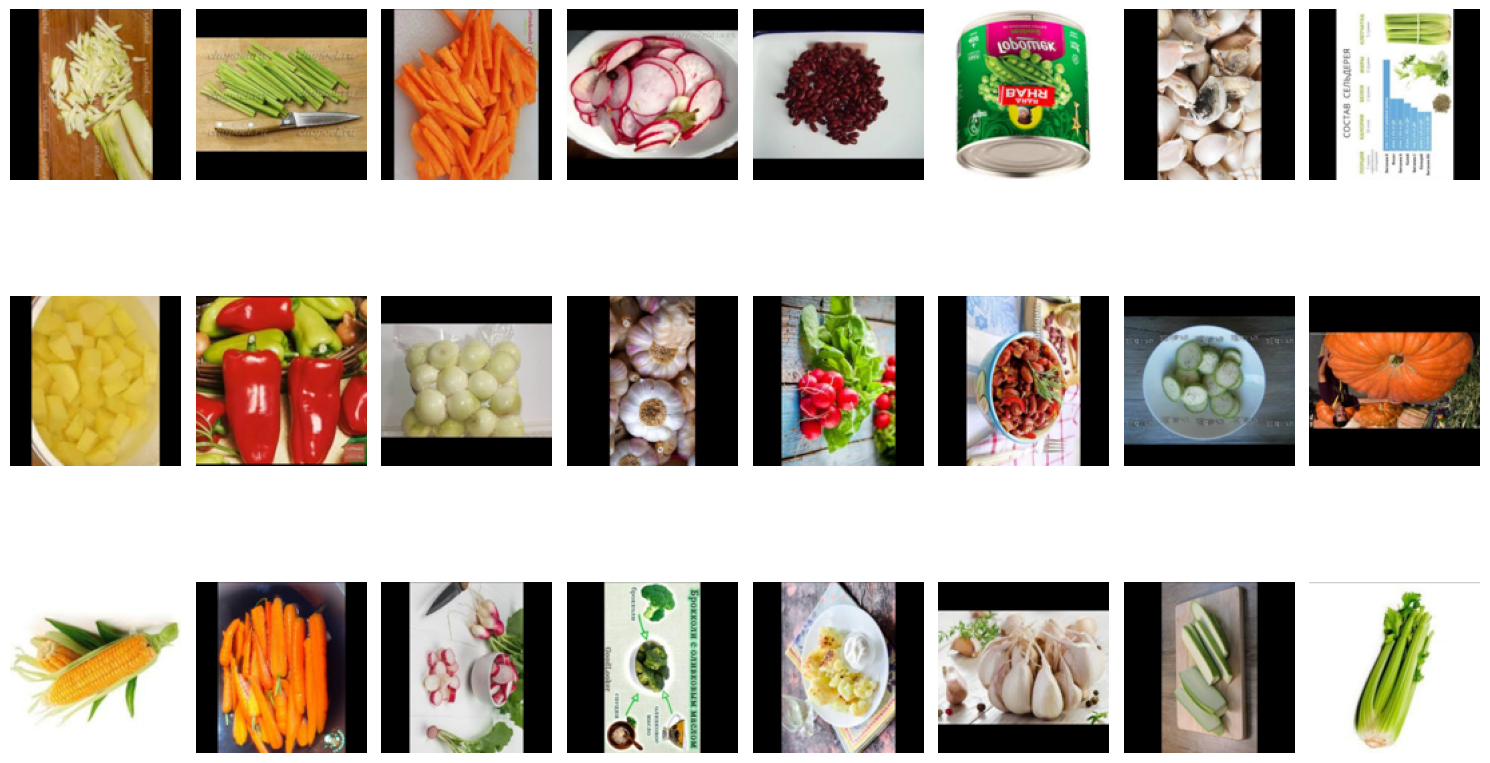

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Путь к изображениям в обучающем наборе
image_dir = "/content/vegetable_data/train/images"

# Получаем список всех изображений
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Выбираем 20 случайных изображений
num_images_to_display = 24
sample_images = random.sample(all_images, min(len(all_images), num_images_to_display))

# Определяем размер сетки (например, 4 ряда по 5 изображений)
rows = 4
cols = 8

plt.figure(figsize=(15, 12)) # Общий размер для всех изображений

for i, img_path in enumerate(sample_images):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(img_path)
    # Изменяем размер изображения, чтобы оно было маленьким
    img.thumbnail((128, 128)) # Уменьшаем изображение до размера 128x128, сохраняя пропорции
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

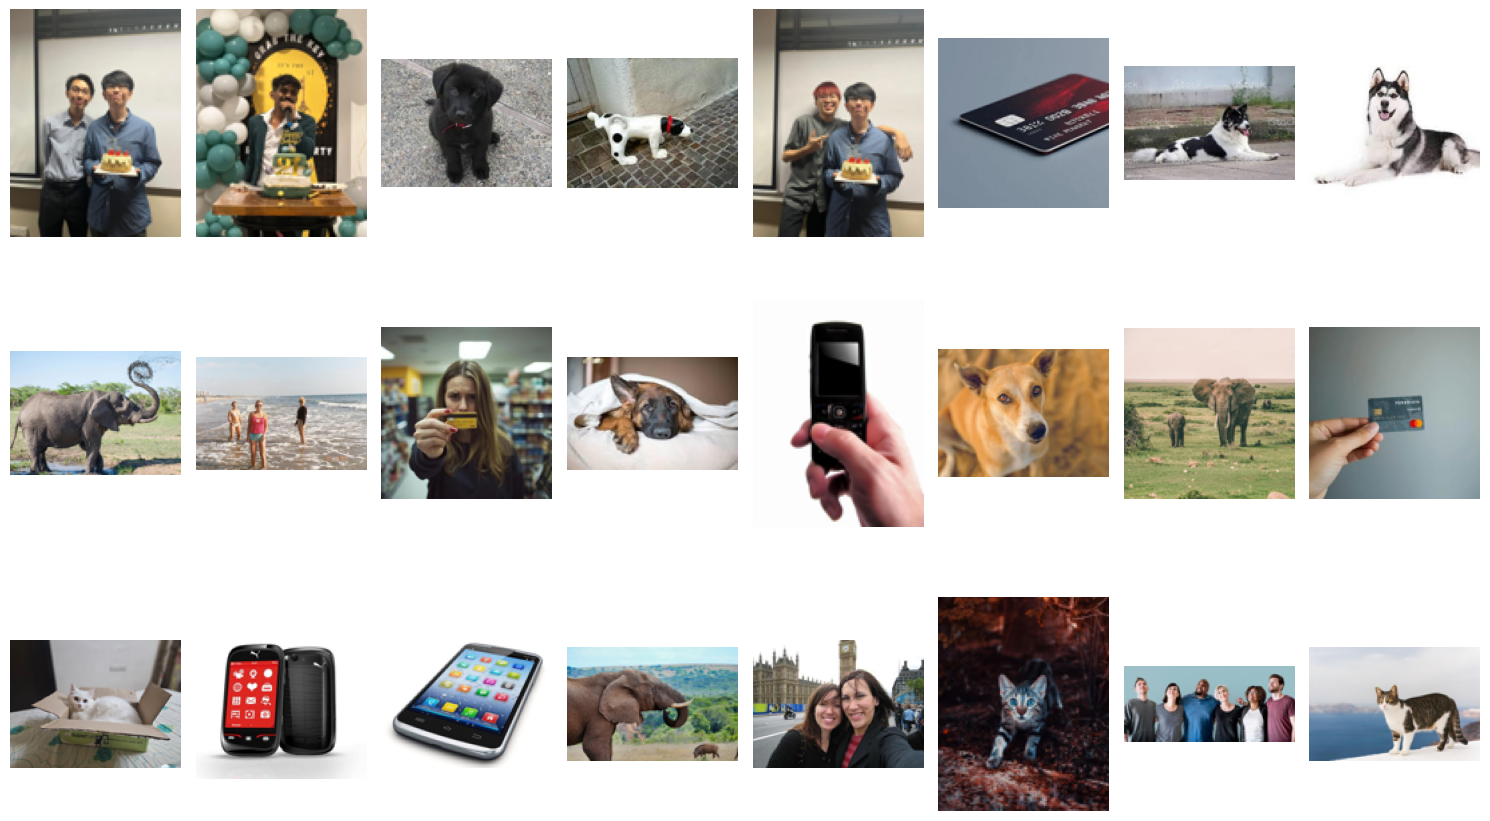

In [ ]:
# Путь к изображениям в обучающем наборе
image_dir = "/content/random_dataset/train/images"

# Получаем список всех изображений
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Выбираем 24 случайных изображений
num_images_to_display = 24
sample_images = random.sample(all_images, min(len(all_images), num_images_to_display))

# Определяем размер сетки (например, 4 ряда по 5 изображений)
rows = 4
cols = 8

plt.figure(figsize=(15, 12)) # Общий размер для всех изображений

for i, img_path in enumerate(sample_images):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(img_path)
    # Изменяем размер изображения, чтобы оно было маленьким
    img.thumbnail((128, 128)) # Уменьшаем изображение до размера 128x128, сохраняя пропорции
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Добавляю объединенный датасет


In [ ]:
import os
import zipfile

zip_file_path = '/content/drive/MyDrive/term_work/final_fruit_vegetable_ds.v2i.yolov8.zip'
extraction_path = '/content/final_full_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Extraction complete. Data extracted to {extraction_path}.")

Extraction complete. Data extracted to /content/final_full_data.


### Модель

In [ ]:
!pip install ultralytics

from ultralytics import YOLOWorld

model = YOLOWorld("yolov8s-worldv2.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Изначальные метрики из коробки на random_dataset

In [ ]:
output_dir = Path("metrics_results")  # папка для всех метрик
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
import yaml

exp_name = "before_training"

model.to("cpu")

# Dynamically load classes from data.yaml for random_dataset
RANDOM_DATA_YAML = "/content/random_dataset/data.yaml"
with open(RANDOM_DATA_YAML, "r") as f:
    random_data = yaml.safe_load(f)
    random_classes = list(random_data["names"])

model.set_classes(random_classes)

model.to("cuda:0")

# Проверка метрик
results = model.val(
    data="/content/random_dataset/data.yaml",
    imgsz=640,
    split="test",
    batch=16
)

box = results.box
class_names = model.names  # {id: name}

per_class_metrics = {}

for i, cls_name in class_names.items():
    per_class_metrics[cls_name] = {
        "precision": float(box.p[i]),
        "recall": float(box.r[i]),
        "f1": float(box.f1[i]),
        "ap50": float(box.ap50[i]),
        "ap50_95": float(box.ap[i])
    }

metrics = {
    "experiment": exp_name,
    "mean": {
        "precision": float(box.mp),
        "recall": float(box.mr),
        "f1": float(np.mean(box.f1)),
        "mAP50": float(box.map50),
        "mAP50-95": float(box.map)
    },
    "per_class": per_class_metrics
}

json_path = output_dir / f"{exp_name}_full_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n\n✅ Полные метрики сохранены в {json_path}")

requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 34 packages in 697ms
Prepared 2 packages in 3.90s
Installed 2 packages in 1ms
 + clip==1.0 (from git+https://github.com/ultralytics/CLIP.git@643beff3883b5720d94b6b9c9eca12fa9fb72fb1)
 + ftfy==6.3.1

requirements: AutoUpdate success ✅ 5.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 42.0MiB/s]


YOLOv8s-worldv2 summary: 236 layers, 164,026,601 parameters, 151,277,313 gradients, 33.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.3±27.1 MB/s, size: 495.0 KB)
val: Scanning /content/random_dataset/test/labels... 70 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 70/70 575.6it/s 0.1s
val: New cache created: /content/random_dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.1s/it 5.5s
                   all         70         92      0.782      0.628      0.799      0.561
                   Dog         22         22      0.637      0.639      0.679      0.263
                   cat          7          7      0.866      0.857      0.909       0.66
           credit card         15         15          1          0      0.701      0.608
             elephants         10         19      0.937      0.778      0.939      0.677
                person          8         22        0.7  

### Сохраяню метрики

In [ ]:
import shutil
import os

# Source path of the metrics JSON file (from the 'before_training' experiment)
source_metric_file = output_dir / "before_training_full_metrics.json"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/metrics"
# Name for the initial metrics (no corresponding weights to match)
drive_dest_filename = "initial_metrics.json"
drive_dest_path = os.path.join(drive_dest_folder, drive_dest_filename)

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_metric_file, drive_dest_path)

print(f"✅ Metrics JSON saved to Google Drive: {drive_dest_path}")

✅ Metrics JSON saved to Google Drive: /content/drive/MyDrive/term_work/metrics/initial_metrics.json


## Перенумерорываю классы у random_dataset

In [ ]:
import os

def renumber_classes(labels_dir, shift_start, shift_end):
    """
    Renumber class IDs in YOLO label files within a given directory
    to a specified new range.

    Args:
        labels_dir (str): Path to the directory containing label files.
        shift_start (int): The starting ID for the new class range.
        shift_end (int): The ending ID for the new class range.
    """

    # 1️⃣ Находим все уникальные class_id в датасете
    unique_ids = set()
    for filename in os.listdir(labels_dir):
        if not filename.endswith(".txt"):
            continue
        filepath = os.path.join(labels_dir, filename)
        with open(filepath, "r") as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip().split()[0])
                    unique_ids.add(class_id)

    unique_ids = sorted(list(unique_ids))
    num_classes = len(unique_ids)

    # Проверка: помещаются ли все в новый диапазон
    if num_classes > (shift_end - shift_start + 1):
        raise ValueError(f"Слишком много классов ({num_classes}) для диапазона {shift_start}-{shift_end}")

    # 2️⃣ Создаём словарь перевода: старый ID -> новый ID
    id_map = {old_id: shift_start + i for i, old_id in enumerate(unique_ids)}
    print(f"Старые ID -> новые ID для {labels_dir}:", id_map)

    # 3️⃣ Перезаписываем файлы с новыми ID
    for filename in os.listdir(labels_dir):
        if not filename.endswith(".txt"):
            continue
        filepath = os.path.join(labels_dir, filename)
        new_lines = []
        with open(filepath, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 0:
                    continue
                old_class_id = int(parts[0])
                # Если класс не найден в id_map, это означает, что он не был уникальным
                # или отсутствовал в файлах, что может указывать на проблему.
                # Для безопасности, можно добавить проверку if old_class_id in id_map:
                new_class_id = id_map[old_class_id]
                new_line = " ".join([str(new_class_id)] + parts[1:])
                new_lines.append(new_line)
        with open(filepath, "w") as f:
            f.write("\n".join(new_lines))

    print(f"Сдвиг class ID для {labels_dir} завершён! Теперь все class_id от {shift_start} до {shift_end}.")

# Пример использования функции:

# Папки с label-файлами random_dataset
labels_dir_train = "/content/random_dataset/train/labels"
labels_dir_test = "/content/random_dataset/test/labels"
labels_dir_valid = "/content/random_dataset/valid/labels"

# Диапазон новых ID, который хотим получить: 26..31
shift_start_val = 26
shift_end_val = 31

# Перенумеровываем классы для каждой папки
renumber_classes(labels_dir_train, shift_start_val, shift_end_val)
renumber_classes(labels_dir_test, shift_start_val, shift_end_val)
renumber_classes(labels_dir_valid, shift_start_val, shift_end_val)


Старые ID -> новые ID для /content/random_dataset/train/labels: {0: 26, 1: 27, 2: 28, 3: 29, 4: 30, 5: 31}
Сдвиг class ID для /content/random_dataset/train/labels завершён! Теперь все class_id от 26 до 31.
Старые ID -> новые ID для /content/random_dataset/test/labels: {0: 26, 1: 27, 2: 28, 3: 29, 4: 30, 5: 31}
Сдвиг class ID для /content/random_dataset/test/labels завершён! Теперь все class_id от 26 до 31.
Старые ID -> новые ID для /content/random_dataset/valid/labels: {0: 26, 1: 27, 2: 28, 3: 29, 4: 30, 5: 31}
Сдвиг class ID для /content/random_dataset/valid/labels завершён! Теперь все class_id от 26 до 31.


## Разделяю данные из vegetable_data стратифицированно


In [ ]:
import os
import shutil
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Путь к исходным данным
DATA_PATH = "vegetable_data/train"

# Пути для новых папок
OUTPUT_PATH = "vegetable_data_split"
TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
VAL_PATH = os.path.join(OUTPUT_PATH, "val")
TEST_PATH = os.path.join(OUTPUT_PATH, "test")

# Создаём папки
for p in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    os.makedirs(os.path.join(p, "images"), exist_ok=True)
    os.makedirs(os.path.join(p, "labels"), exist_ok=True)

# Получаем все изображения
all_images = [f for f in os.listdir(os.path.join(DATA_PATH, "images")) if f.endswith((".jpg",".png"))]

# Строим словарь {image_name: [классы в аннотации]}
image_classes = {}
for img_file in all_images:
    label_file = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
    with open(label_file, "r") as f:
        classes = [int(line.strip().split()[0]) for line in f.readlines()]
    image_classes[img_file] = classes

# Для стратификации берём первый класс в image (можно усреднять, но первый проще)
image_first_class = {img: classes[0] if classes else -1 for img, classes in image_classes.items()}

# Список изображений и меток
X = list(image_first_class.keys())
y = [image_first_class[img] for img in X]

# 1. Разделяем на train (75%) и temp (25% = val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 2. Разделяем temp на val (15%) и test (10%)
# Пропорция внутри temp: val 15/25=0.6, test 10/25=0.4
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42
)

# Функция для копирования файлов
def copy_files(file_list, dest_path):
    for img_file in file_list:
        src_img = os.path.join(DATA_PATH, "images", img_file)
        src_label = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
        dst_img = os.path.join(dest_path, "images", img_file)
        dst_label = os.path.join(dest_path, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
        shutil.copy2(src_img, dst_img)
        shutil.copy2(src_label, dst_label)

# Копируем
copy_files(X_train, TRAIN_PATH)
copy_files(X_val, VAL_PATH)
copy_files(X_test, TEST_PATH)

print(f"Train: {len(X_train)} images")
print(f"Val:   {len(X_val)} images")
print(f"Test:  {len(X_test)} images")


Train: 3748 images
Val:   750 images
Test:  500 images


## Добавляю random_data к vegetable_data

In [ ]:
# import shutil
# import glob
# import os

# # Папки
# veg_val_images = "/content/vegetable_data_split/train/images"
# veg_val_labels = "/content/vegetable_data_split/train/labels"

# rnd_val_images = "/content/random_dataset/train/images"
# rnd_val_labels = "/content/random_dataset/train/labels"

# # Копируем изображения
# for img_path in glob.glob(rnd_val_images + "/*"):
#     shutil.copy(img_path, veg_val_images)

# # Копируем метки
# for lbl_path in glob.glob(rnd_val_labels + "/*"):
#     shutil.copy(lbl_path, veg_val_labels)

# print("random_dataset/train добавлен в vegetable_data_split")


In [ ]:
import shutil
import glob
import os

# Папки
veg_val_images = "/content/vegetable_data_split/val/images"
veg_val_labels = "/content/vegetable_data_split/val/labels"

rnd_val_images = "/content/random_dataset/valid/images"
rnd_val_labels = "/content/random_dataset/valid/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/val добавлен в vegetable_data")


random_dataset/val добавлен в vegetable_data


In [ ]:
import shutil
import glob
import os

# Папки
veg_val_images = "/content/vegetable_data_split/test/images"
veg_val_labels = "/content/vegetable_data_split/test/labels"

rnd_val_images = "/content/random_dataset/test/images"
rnd_val_labels = "/content/random_dataset/test/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/test добавлен в vegetable_data")


random_dataset/test добавлен в vegetable_data


## Обучение: train только vegetable, test and valid оба датасета

In [ ]:
import yaml
import os

VEGETABLE_DATA_YAML = "/content/vegetable_data/data.yaml"
RANDOM_DATA_YAML = "/content/random_dataset/data.yaml"
OUTPUT_YAML_PATH = "/content/vegetable_data_split/data.yaml"

# Load names from vegetable_data/data.yaml
with open(VEGETABLE_DATA_YAML, "r") as f:
    veg_data = yaml.safe_load(f)
    veg_names = veg_data["names"]

# Load names from random_dataset/data.yaml
with open(RANDOM_DATA_YAML, "r") as f:
    random_data_yaml = yaml.safe_load(f)
    random_names = random_data_yaml["names"]

# Combine names, re-indexing for the output YAML
combined_names = {}
current_idx = 0
for name in veg_names:
    combined_names[current_idx] = name
    current_idx += 1
for name in random_names:
    combined_names[current_idx] = name
    current_idx += 1

# Prepare the content for the data.yaml file
yaml_content = f"""
path: /content/vegetable_data_split

train: /content/vegetable_data_split/train/images
val: /content/vegetable_data_split/val/images
test: /content/vegetable_data_split/test/images

names:
"""

for idx, name in combined_names.items():
    yaml_content += f"  {idx}: {name}\n"

# Write the combined content to the file
with open(OUTPUT_YAML_PATH, "w") as f:
    f.write(yaml_content)

print(f"Combined data.yaml written to {OUTPUT_YAML_PATH}")

Combined data.yaml written to /content/vegetable_data_split/data.yaml


### проверю метрики на vegetable до обучения

In [ ]:
import yaml

exp_name = "before_training_vegetable"

model.to("cpu")

# Dynamically load classes from data.yaml for the combined dataset
# The names in the YAML are stored as a dictionary {id: name}, so we need to get the values
COMBINED_DATA_YAML = "/content/vegetable_data_split/data.yaml"
with open(COMBINED_DATA_YAML, "r") as f:
    combined_data = yaml.safe_load(f)
    # Corrected line: Get the list of class names (values) instead of keys
    combined_classes = list(combined_data["names"].values())

model.set_classes(combined_classes)

model.to("cuda:0")

# Проверка метрик
results = model.val(
    data="/content/vegetable_data_split/data.yaml",
    imgsz=640,
    split="test",
    batch=16
)

box = results.box
class_names = model.names  # {id: name}

per_class_metrics = {}

for i, cls_name in class_names.items():
    # Ensure the class index is within the bounds of `box.p`, `box.r`, etc.
    # Some classes might not have detections in the test set, leading to missing metrics
    if i < len(box.p):
        per_class_metrics[cls_name] = {
            "precision": float(box.p[i]),
            "recall": float(box.r[i]),
            "f1": float(box.f1[i]),
            "ap50": float(box.ap50[i]),
            "ap50_95": float(box.ap[i])
        }
    else:
        # Handle cases where a class might not appear in the test set and thus has no metrics
        # For example, by setting them to 0 or omitting them
        per_class_metrics[cls_name] = {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
            "ap50": 0.0,
            "ap50_95": 0.0
        }

metrics = {
    "experiment": exp_name,
    "mean": {
        "precision": float(box.mp),
        "recall": float(box.mr),
        "f1": float(np.mean(box.f1)), # Use np.mean(box.f1) as before
        "mAP50": float(box.map50),
        "mAP50-95": float(box.map)
    },
    "per_class": per_class_metrics
}

json_path = output_dir / f"{exp_name}_full_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n\n✅ Полные метрики сохранены в {json_path}")

YOLOv8s-worldv2 summary: 236 layers, 164,026,601 parameters, 151,277,313 gradients, 39.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1171.3±368.6 MB/s, size: 28.1 KB)
val: Scanning /content/vegetable_data_split/test/labels... 570 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 570/570 2.4Kit/s 0.2s
val: New cache created: /content/vegetable_data_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 2.8it/s 12.7s
                   all        570       1764      0.476      0.237      0.214      0.139
               avocado         23         53       0.14     0.0189     0.0789     0.0435
                 beans         16         34      0.314     0.0294     0.0441     0.0225
                  beet         20         45          1          0     0.0147     0.0104
           bell pepper         23         96     0.0691      0.531      0.101     0.0706
              broccoli         22     

### Сохраяню метрики

In [ ]:
import shutil
import os

# Source path of the metrics JSON file (from the 'before_training' experiment)
source_metric_file = output_dir / "before_training_vegetable_full_metrics.json"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/metrics"
# Name for the initial metrics (no corresponding weights to match)
drive_dest_filename = "initial_metrics_on_vegetable.json"
drive_dest_path = os.path.join(drive_dest_folder, drive_dest_filename)

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_metric_file, drive_dest_path)

print(f"✅ Metrics JSON saved to Google Drive: {drive_dest_path}")

✅ Metrics JSON saved to Google Drive: /content/drive/MyDrive/term_work/metrics/initial_metrics_on_vegetable.json


### Будет ли так лучше?

In [ ]:
# model = YOLOWorld("yolov8s-worldv2.pt")

# # Замораживаем backbone вручную
# for param in model.model.backbone.parameters():
#     param.requires_grad = False

# # Запуск тренировки на новых классах
# results = model.train(
#     data="/content/vegetable_data_split/data.yaml",
#     epochs=25,
#     imgsz=640,
#     batch=16,
#     lr0=0.0005,
#     lrf=0.01,
#     cos_lr=True,
#     # только поддерживаемые параметры
#     mixup=0.1
# )

In [ ]:
# import shutil
# import os

# folder_to_delete = "runs/detect/train"

# if os.path.exists(folder_to_delete):
#     shutil.rmtree(folder_to_delete)
#     print(f"Folder '{folder_to_delete}' deleted successfully.")
# else:
#     print(f"Folder '{folder_to_delete}' does not exist.")

Folder 'runs/detect/train' deleted successfully.


In [ ]:
# обнуляю модель, чтобы обучение шло с нуля
model = YOLOWorld("yolov8s-worldv2.pt")

model.train(
    data="/content/vegetable_data_split/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    lr0=0.0005,
    lrf=0.01,             # финальный learning rate
    cos_lr=True,
    freeze=-9,
    mixup=0.1,          # помогает не забывать старые классы
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/vegetable_data_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=-9, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s-worldv2.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79192810d6a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

### Сохраняю веса

In [ ]:
import shutil
import os

# Source path of the best model weights after training
source_path = "runs/detect/train/weights/best.pt"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/weights"
drive_dest_path = os.path.join(drive_dest_folder, "best_only_vegetable.pt")

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_path, drive_dest_path)

print(f"✅ Model weights saved to Google Drive: {drive_dest_path}")

✅ Model weights saved to Google Drive: /content/drive/MyDrive/term_work/weights/best_only_vegetable.pt


### Сохраяню метрики

In [ ]:
exp_name = "after_training_on_vegetable"

results = model.val(
    data="/content/vegetable_data_split/data.yaml",
    imgsz=640,
    split="test",
    batch=16
)

box = results.box
class_names = model.names  # {id: name}

per_class_metrics = {}

for i, cls_name in class_names.items():
    per_class_metrics[cls_name] = {
        "precision": float(box.p[i]),
        "recall": float(box.r[i]),
        "f1": float(box.f1[i]),
        "ap50": float(box.ap50[i]),
        "ap50_95": float(box.ap[i])
    }

metrics = {
    "experiment": exp_name,
    "mean": {
        "precision": float(box.mp),
        "recall": float(box.mr),
        "f1": float(np.mean(box.f1)),
        "mAP50": float(box.map50),
        "mAP50-95": float(box.map)
    },
    "per_class": per_class_metrics
}

json_path = output_dir / f"{exp_name}_full_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n\n✅ Полные метрики сохранены в {json_path}")


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-worldv2 summary (fused): 88 layers, 12,749,288 parameters, 0 gradients, 39.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.3±4.0 MB/s, size: 29.5 KB)
val: Scanning /content/vegetable_data_split/test/labels... 570 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 570/570 515.7it/s 1.1s
val: New cache created: /content/vegetable_data_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 2.6it/s 14.0s
                   all        570       1764      0.592      0.399      0.477      0.314
               avocado         23         53      0.587      0.804      0.757      0.489
                 beans         16         34        0.4      0.235      0.293      0.201
                  beet         20         45      0.333      0.622       0.38      0.289
           bell pepper         23         96      0.53

In [ ]:
import shutil
import os

# Source path of the metrics JSON file (from the 'after_training_on_vegetable' experiment)
source_metric_file = output_dir / "after_training_on_vegetable_full_metrics.json"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/metrics"
# Name for these metrics, matching 'best_only_vegetable.pt'
drive_dest_filename = "best_only_vegetable_metrics.json"
drive_dest_path = os.path.join(drive_dest_folder, drive_dest_filename)

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_metric_file, drive_dest_path)

print(f"✅ Metrics JSON saved to Google Drive: {drive_dest_path}")

✅ Metrics JSON saved to Google Drive: /content/drive/MyDrive/term_work/metrics/best_only_vegetable_metrics.json


## Два датасетах

In [ ]:
# добавляю в vegetable_data_split train из random_data

import shutil
import glob
import os

# Папки
veg_val_images = "/content/vegetable_data_split/train/images"
veg_val_labels = "/content/vegetable_data_split/train/labels"

rnd_val_images = "/content/random_dataset/train/images"
rnd_val_labels = "/content/random_dataset/train/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/train добавлен в vegetable_data_split")


random_dataset/train добавлен в vegetable_data_split


In [ ]:
# обнуляю модель, чтобы обучение шло с нуля
model = YOLOWorld("yolov8s-worldv2.pt")

model.train(
    data="/content/vegetable_data_split/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    lr0=0.0005,
    lrf=0.01,             # финальный learning rate
    cos_lr=True,
    freeze=-9,
    mixup=0.1,          # помогает не забывать старые классы
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/vegetable_data_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=-9, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s-worldv2.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa4912b6d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

### Сохраняю веса

In [ ]:
import shutil
import os

# Source path of the best model weights after training
source_path = "runs/detect/train2/weights/best.pt"



# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/weights"
drive_dest_path = os.path.join(drive_dest_folder, "best_both_data.pt")

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_path, drive_dest_path)

print(f"✅ Model weights saved to Google Drive: {drive_dest_path}")

✅ Model weights saved to Google Drive: /content/drive/MyDrive/term_work/weights/best_both_data.pt


### Сохраяню метрики

In [ ]:
exp_name = "after_training_on_both"

results = model.val(
    data="/content/vegetable_data_split/data.yaml",
    imgsz=640,
    split="test",
    batch=16
)

box = results.box
class_names = model.names  # {id: name}

per_class_metrics = {}

for i, cls_name in class_names.items():
    per_class_metrics[cls_name] = {
        "precision": float(box.p[i]),
        "recall": float(box.r[i]),
        "f1": float(box.f1[i]),
        "ap50": float(box.ap50[i]),
        "ap50_95": float(box.ap[i])
    }

metrics = {
    "experiment": exp_name,
    "mean": {
        "precision": float(box.mp),
        "recall": float(box.mr),
        "f1": float(np.mean(box.f1)),
        "mAP50": float(box.map50),
        "mAP50-95": float(box.map)
    },
    "per_class": per_class_metrics
}

json_path = output_dir / f"{exp_name}_full_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n\n✅ Полные метрики сохранены в {json_path}")


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 23.3±15.2 MB/s, size: 30.4 KB)
val: Scanning /content/vegetable_data_split/test/labels... 570 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 570/570 664.0it/s 0.9s
val: New cache created: /content/vegetable_data_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 3.0it/s 12.1s
                   all        570       1764      0.532      0.542      0.543      0.366
               avocado         23         53      0.601      0.868      0.828      0.528
                 beans         16         34      0.362      0.235      0.259      0.178
                  beet         20         45       0.35      0.622      0.385      0.288
           bell pepper         23         96      0.581      0.521      0.546       0.42
              broccoli         22         54      0.556

In [ ]:
import shutil
import os

# Source path of the metrics JSON file (from the 'after_training_on_both' experiment)
source_metric_file = output_dir / "after_training_on_both_full_metrics.json"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/metrics"
# Name for these metrics, matching 'best_both_data.pt'
drive_dest_filename = "best_both_data_metrics.json"
drive_dest_path = os.path.join(drive_dest_folder, drive_dest_filename)

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_metric_file, drive_dest_path)

print(f"✅ Metrics JSON saved to Google Drive: {drive_dest_path}")

✅ Metrics JSON saved to Google Drive: /content/drive/MyDrive/term_work/metrics/best_both_data_metrics.json


## Графики

In [ ]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

metrics_dir = Path("metrics_results")
metrics_files = list(metrics_dir.glob("*_metrics.json"))

# Считаем все метрики
all_metrics = {}
for f in metrics_files:
    name = f.stem.replace("_metrics", "")
    with open(f, "r") as j:
        all_metrics[name] = json.load(j)

# Пример: сравнение mAP50 и mAP50-95
labels = list(all_metrics.keys())
map50 = [all_metrics[l]["mean"]["mAP50"] for l in labels]
map50_95 = [all_metrics[l]["mean"]["mAP50-95"] for l in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, map50, alpha=0.6, label="mAP50")
plt.bar(labels, map50_95, alpha=0.6, label="mAP50-95")
plt.ylabel("mAP")
plt.title("Сравнение mAP между экспериментами")
plt.legend()
plt.show()

# Аналогично можно нарисовать precision, recall, F1
precision = [all_metrics[l]["mean"]["precision"] for l in labels]
recall = [all_metrics[l]["mean"]["recall"] for l in labels]
f1 = [all_metrics[l]["mean"]["f1"] for l in labels]

plt.figure(figsize=(8,5))
plt.plot(labels, precision, marker='o', label="Precision")
plt.plot(labels, recall, marker='o', label="Recall")
plt.plot(labels, f1, marker='o', label="F1")
plt.title("Сравнение метрик между экспериментами")
plt.legend()
plt.show()

## Улучшенные графики метрик

In [ ]:
# import json
# import matplotlib.pyplot as plt
# import numpy as np
# from pathlib import Path

# # Устанавливаем стиль для графиков
# plt.style.use('seaborn-v0_8-darkgrid') # Можно попробовать 'ggplot', 'fivethirtyeight' и другие

# metrics_dir = Path("metrics_results")
# metrics_files = list(metrics_dir.glob("*_metrics.json"))

# # Считаем все метрики
# all_metrics = {}
# for f in metrics_files:
#     name = f.stem.replace("_full_metrics", "") # Изменил название файла, чтобы оно соответствовало созданным файлам
#     with open(f, "r") as j:
#         all_metrics[name] = json.load(j) # Загружаем весь JSON, включая 'mean' и 'per_class'

# # Извлекаем данные для графиков
# labels = list(all_metrics.keys())

# # Получаем средние метрики (mean) для каждого эксперимента
# map50_mean = [all_metrics[l]["mean"]["mAP50"] for l in labels]
# map50_95_mean = [all_metrics[l]["mean"]["mAP50-95"] for l in labels]
# precision_mean = [all_metrics[l]["mean"]["precision"] for l in labels]
# recall_mean = [all_metrics[l]["mean"]["recall"] for l in labels]
# f1_mean = [all_metrics[l]["mean"]["f1"] for l in labels]

# # --- График mAP50 и mAP50-95 ---
# fig, ax = plt.subplots(figsize=(10, 6))

# bar_width = 0.35
# index = np.arange(len(labels))

# rects1 = ax.bar(index - bar_width/2, map50_mean, bar_width, label='mAP50', color='#1f77b4', alpha=0.8)
# rects2 = ax.bar(index + bar_width/2, map50_95_mean, bar_width, label='mAP50-95', color='#ff7f0e', alpha=0.8)

# ax.set_xlabel('Эксперимент', fontsize=12)
# ax.set_ylabel('Значение mAP', fontsize=12)
# ax.set_title('Сравнение средних mAP50 и mAP50-95 между экспериментами', fontsize=14)
# ax.set_xticks(index)
# ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
# ax.legend(fontsize=10)
# ax.set_ylim(0, 1.0) # Метрики обычно от 0 до 1
# fig.tight_layout()
# plt.show()

# # --- График Precision, Recall, F1 ---
# fig, ax = plt.subplots(figsize=(12, 7))

# bar_width = 0.2
# index = np.arange(len(labels))

# rects1 = ax.bar(index - bar_width, precision_mean, bar_width, label='Precision', color='#2ca02c', alpha=0.8)
# rects2 = ax.bar(index, recall_mean, bar_width, label='Recall', color='#d62728', alpha=0.8)
# rects3 = ax.bar(index + bar_width, f1_mean, bar_width, label='F1 Score', color='#9467bd', alpha=0.8)

# ax.set_xlabel('Эксперимент', fontsize=12)
# ax.set_ylabel('Значение метрики', fontsize=12)
# ax.set_title('Сравнение средних Precision, Recall и F1 между экспериментами', fontsize=14)
# ax.set_xticks(index)
# ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
# ax.legend(fontsize=10)
# ax.set_ylim(0, 1.0) # Метрики обычно от 0 до 1
# fig.tight_layout()
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the random data classes based on the original list (before ID shifting for display)
random_classes = ['Dog', 'cat', 'credit card', 'elephants', 'person', 'phone']

# Extract metrics for the specified classes from the two relevant experiments
metrics_before = all_metrics['before_training_full']['per_class']
metrics_after = all_metrics['after_training_on_both_full']['per_class']

# Prepare data for plotting
metrics_to_compare = {
    # 'Precision': ('precision', 'P'),
    # 'Recall': ('recall', 'R'),
    'F1 Score': ('f1', 'F1'),
    # 'mAP50': ('ap50', 'AP50'),
    'mAP50-95': ('ap50_95', 'AP50-95')
}

# Plotting loop for each metric
for metric_name, (metric_key, metric_label) in metrics_to_compare.items():
    before_values = [metrics_before.get(cls, {}).get(metric_key, 0.0) for cls in random_classes]
    after_values = [metrics_after.get(cls, {}).get(metric_key, 0.0) for cls in random_classes]

    x = np.arange(len(random_classes))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, before_values, width, label='Before Training', color='#1f77b4', alpha=0.8)
    rects2 = ax.bar(x + width/2, after_values, width, label='After Training on Both', color='#ff7f0e', alpha=0.8)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Comparison for Random Data Classes')
    ax.set_xticks(x)
    ax.set_xticklabels(random_classes, rotation=45, ha="right")
    ax.legend()
    ax.set_ylim(0, 1.0) # Metrics usually range from 0 to 1

    fig.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the vegetable classes (assuming IDs 0-25 from data.yaml)
# We need to get the class names from the model's names dictionary
vegetable_classes = []
# Assuming model.names is available from a previous cell execution or can be re-initialized
# For robustness, we will try to load it from the 'after_training_on_vegetable_full' metrics as it contains all names
if 'after_training_on_vegetable_full' in all_metrics and 'per_class' in all_metrics['after_training_on_vegetable_full']:
    for i in range(26): # IDs 0 to 25 are vegetable classes
        # Find class name by ID. The per_class dict keys are names, so we need to map back
        # A more robust way is to load the data.yaml again to get the name mapping directly
        # Let's assume the order in 'per_class' dictionary reflects the ID order for vegetable classes 0-25.
        # Or, we can use the `class_names` variable if it's still in scope from previous cell `TQHtpI9NsnPF`
        if 'class_names' in globals(): # Check if class_names is available from before
            vegetable_classes.append(class_names[i])
        else:
            # Fallback if class_names isn't globally available, might need to infer or hardcode based on data.yaml
            # This is less ideal but works if the original class names are consistent
            # For this example, let's just get them directly from the full_yaml
            import yaml
            with open("/content/full_yaml/data.yaml") as f:
                data = yaml.safe_load(f)
            vegetable_classes = [data["names"][j] for j in range(26)]
            break
else:
    print("Could not reliably determine vegetable class names from metrics_results. Please ensure 'after_training_on_vegetable_full' exists.")
    vegetable_classes = [] # Empty list to prevent errors

if not vegetable_classes:
    print("Warning: Vegetable class names could not be determined. Plotting will be skipped.")
else:
    # Extract metrics for the specified classes from the two relevant experiments
    metrics_veg_only_train = all_metrics['after_training_on_vegetable_full']['per_class']
    metrics_both_train = all_metrics['after_training_on_both_full']['per_class']

    # Prepare data for plotting
    metrics_to_compare = {
        'F1 Score': ('f1', 'F1'),
        # 'mAP50': ('ap50', 'AP50'),
        'mAP50-95': ('ap50_95', 'AP50-95')
    }

    # Plotting loop for each metric
    for metric_name, (metric_key, metric_label) in metrics_to_compare.items():
        veg_only_values = [metrics_veg_only_train.get(cls, {}).get(metric_key, 0.0) for cls in vegetable_classes]
        both_train_values = [metrics_both_train.get(cls, {}).get(metric_key, 0.0) for cls in vegetable_classes]

        x = np.arange(len(vegetable_classes))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots(figsize=(15, 7))
        rects1 = ax.bar(x - width/2, veg_only_values, width, label='Trained on Vegetables Only', color='#2ca02c', alpha=0.8)
        rects2 = ax.bar(x + width/2, both_train_values, width, label='Trained on Both Datasets', color='#17becf', alpha=0.8)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} Comparison for Vegetable Classes')
        ax.set_xticks(x)
        ax.set_xticklabels(vegetable_classes, rotation=90, ha="right", fontsize=8) # Rotate for better readability
        ax.legend()
        ax.set_ylim(0, 1.0) # Metrics usually range from 0 to 1

        fig.tight_layout()
        plt.show()


## Разделяю объединенный датасет стратифицированно, и перенумерорываю классы у random

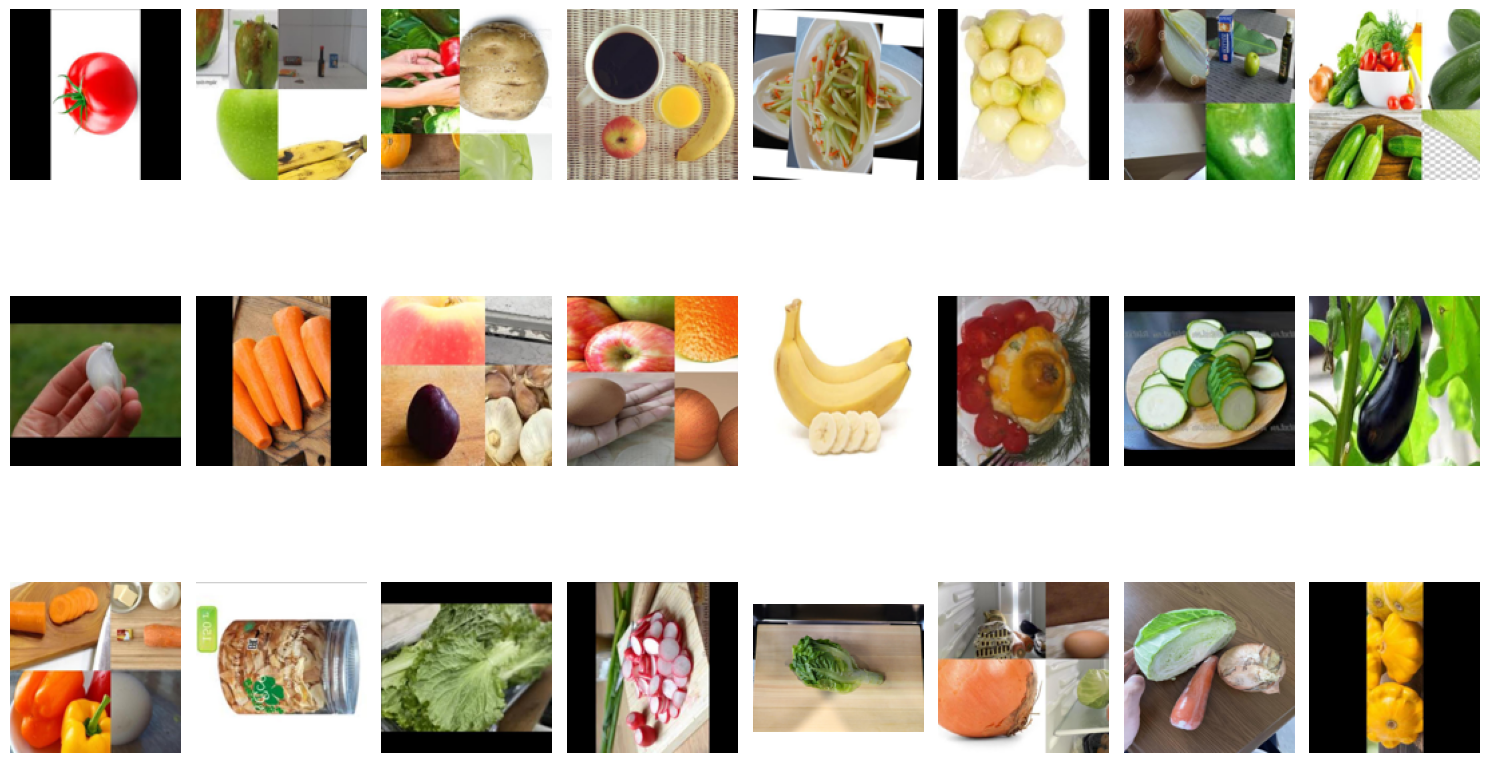

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Путь к изображениям в обучающем наборе
image_dir = "/content/final_full_data/train/images"

# Получаем список всех изображений
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Выбираем 20 случайных изображений
num_images_to_display = 24
sample_images = random.sample(all_images, min(len(all_images), num_images_to_display))

# Определяем размер сетки (например, 4 ряда по 5 изображений)
rows = 4
cols = 8

plt.figure(figsize=(15, 12)) # Общий размер для всех изображений

for i, img_path in enumerate(sample_images):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(img_path)
    # Изменяем размер изображения, чтобы оно было маленьким
    img.thumbnail((128, 128)) # Уменьшаем изображение до размера 128x128, сохраняя пропорции
    plt.imshow(img)
    # plt.title(os.path.basename(img_path), fontsize=8) # Добавляем название файла
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Путь к исходным данным
DATA_PATH = "final_full_data/train"

# Пути для новых папок
OUTPUT_PATH = "final_full_data_split"
TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
VAL_PATH = os.path.join(OUTPUT_PATH, "val")
TEST_PATH = os.path.join(OUTPUT_PATH, "test")

# Создаём папки
for p in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
    os.makedirs(os.path.join(p, "images"), exist_ok=True)
    os.makedirs(os.path.join(p, "labels"), exist_ok=True)

# Получаем все изображения
all_images = [f for f in os.listdir(os.path.join(DATA_PATH, "images")) if f.endswith((".jpg",".png"))]

# Строим словарь {image_name: [классы в аннотации]}
image_classes = {}
for img_file in all_images:
    label_file = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
    with open(label_file, "r") as f:
        classes = [int(line.strip().split()[0]) for line in f.readlines()]
    image_classes[img_file] = classes

# Для стратификации берём первый класс в image (можно усреднять, но первый проще)
image_first_class = {img: classes[0] if classes else -1 for img, classes in image_classes.items()}

# Список изображений и меток
X = list(image_first_class.keys())
y = [image_first_class[img] for img in X]

# 1. Разделяем на train (75%) и temp (25% = val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 2. Разделяем temp на val (15%) и test (10%)
# Пропорция внутри temp: val 15/25=0.6, test 10/25=0.4
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42
)

# Функция для копирования файлов
def copy_files(file_list, dest_path):
    for img_file in file_list:
        src_img = os.path.join(DATA_PATH, "images", img_file)
        src_label = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
        dst_img = os.path.join(dest_path, "images", img_file)
        dst_label = os.path.join(dest_path, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
        shutil.copy2(src_img, dst_img)
        shutil.copy2(src_label, dst_label)

# Копируем
copy_files(X_train, TRAIN_PATH)
copy_files(X_val, VAL_PATH)
copy_files(X_test, TEST_PATH)

print(f"Train: {len(X_train)} images")
print(f"Val:   {len(X_val)} images")
print(f"Test:  {len(X_test)} images")


Train: 11438 images
Val:   2287 images
Test:  1526 images


Total number of classes: 28

--- Train Split ---
Number of images: 15251
Class distribution (ID: count):
  apple: 2371 instances
  avocado: 786 instances
  banana: 2755 instances
  beans: 512 instances
  beet: 3799 instances
  bell pepper: 3951 instances
  brinjal: 3048 instances
  broccoli: 587 instances
  cabbage: 2492 instances
  carrot: 5440 instances
  cayliflower: 453 instances
  corn: 744 instances
  cucumber: 5778 instances
  eggplant: 578 instances
  garlic: 3255 instances
  hot pepper: 907 instances
  onion: 5122 instances
  orange: 2400 instances
  peas: 685 instances
  potato: 3325 instances
  pumpkin: 695 instances
  radish: 1250 instances
  rediska: 710 instances
  salad: 409 instances
  seledri: 1068 instances
  squash-patisson: 665 instances
  tomato: 5383 instances
  zucchini: 2516 instances

--- Overall Dataset Summary ---
Total number of unique classes detected: 28
Image counts per split:
  Train: 15251 images


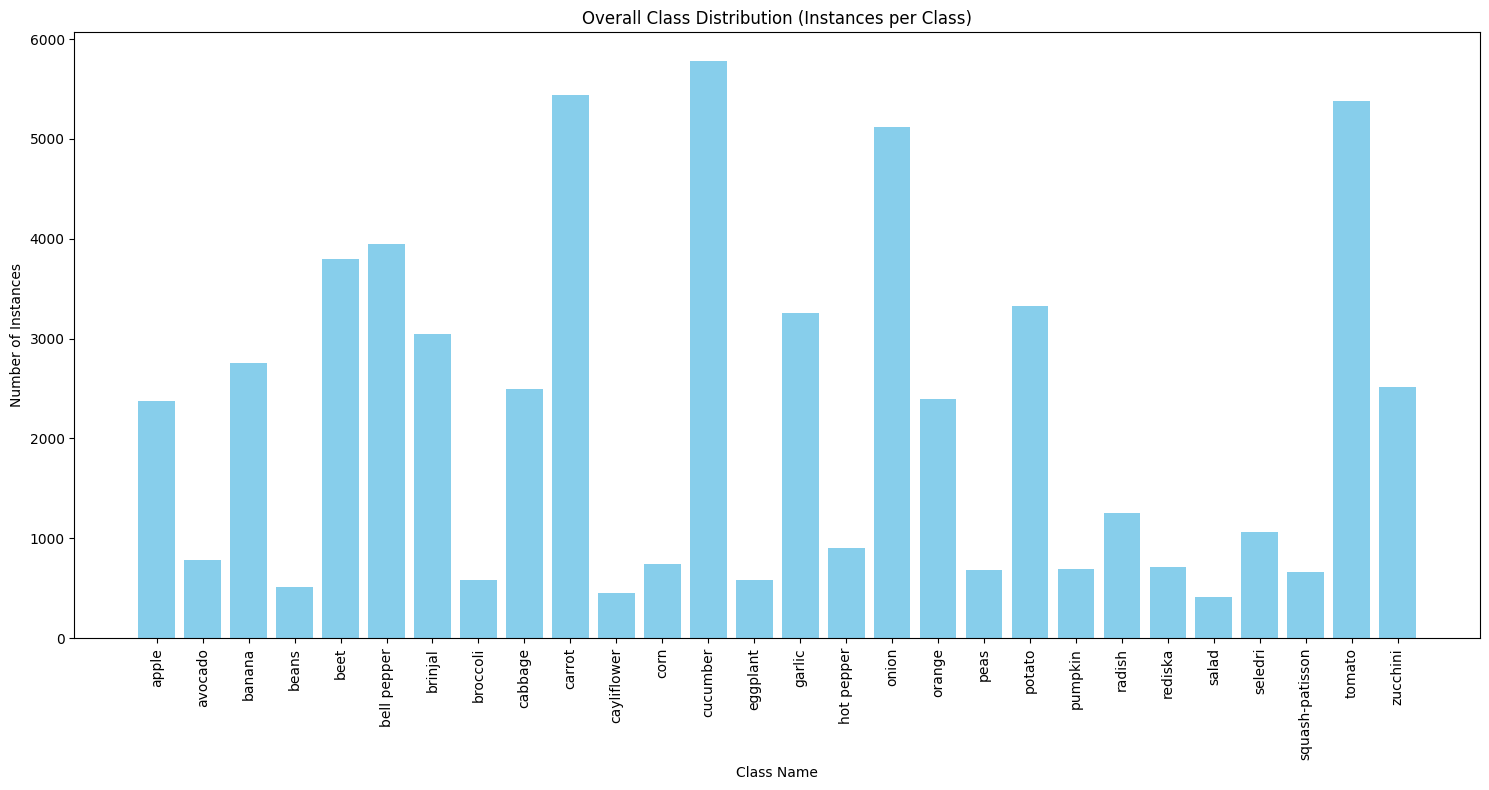

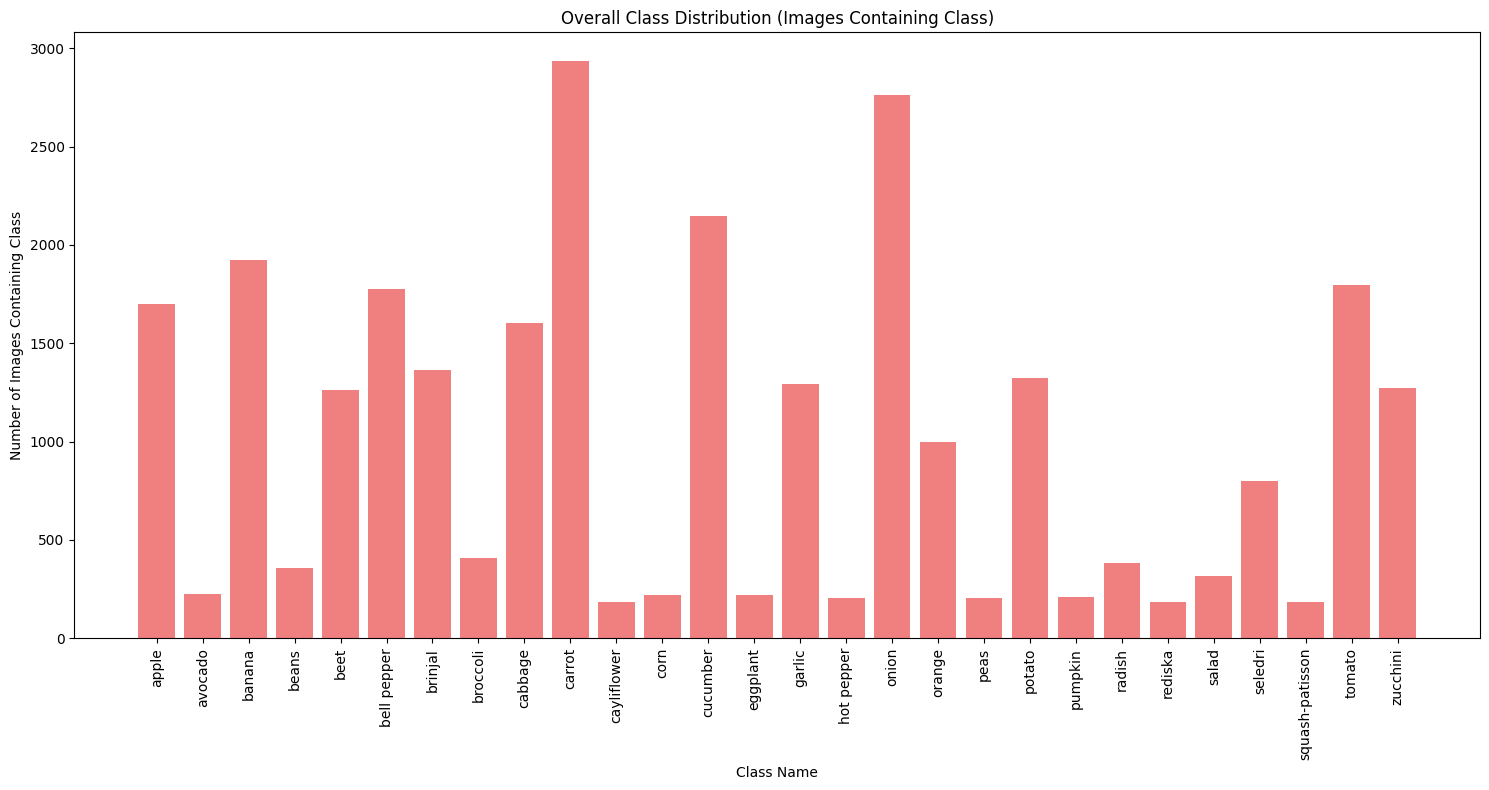

In [ ]:
import os
import yaml
import matplotlib.pyplot as plt
from collections import Counter

DATASET_ROOT = "/content/final_full_data"
YAML_PATH = "/content/final_full_data/data.yaml" # Use the yaml with all class names

# Load class names
with open(YAML_PATH, "r") as f:
    yaml_data = yaml.safe_load(f)
    id2name = yaml_data["names"]

print(f"Total number of classes: {len(id2name)}")

all_class_instances_counts = Counter()
split_image_counts = {}

splits = ["train", "val", "test"]

for split in splits:
    labels_dir = os.path.join(DATASET_ROOT, split, "labels")
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory for {split} not found at {labels_dir}")
        continue

    current_split_instance_counts = Counter()
    image_count = 0
    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            image_count += 1
            file_path = os.path.join(labels_dir, label_file)
            with open(file_path, "r") as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.strip().split()[0])
                        current_split_instance_counts[class_id] += 1

    split_image_counts[split] = image_count
    all_class_instances_counts.update(current_split_instance_counts) # Aggregate instance counts for overall histogram

    print(f"\n--- {split.capitalize()} Split ---")
    print(f"Number of images: {image_count}")
    print("Class distribution (ID: count):")
    for cls_id in sorted(current_split_instance_counts.keys()):
        class_name = id2name[cls_id] if 0 <= cls_id < len(id2name) else f"Unknown Class {cls_id}"
        print(f"  {class_name}: {current_split_instance_counts[cls_id]} instances")

print("\n--- Overall Dataset Summary ---")
print(f"Total number of unique classes detected: {len(all_class_instances_counts)}")
print("Image counts per split:")
for split, count in split_image_counts.items():
    print(f"  {split.capitalize()}: {count} images")

# --- Plot: Overall Class Distribution (Instances per Class) ---
class_ids = sorted(all_class_instances_counts.keys())
class_names_for_plot = [id2name[cid] if 0 <= cid < len(id2name) else f"Unknown {cid}" for cid in class_ids]
counts = [all_class_instances_counts[cid] for cid in class_ids]

plt.figure(figsize=(15, 8))
plt.bar(class_names_for_plot, counts, color='skyblue')
plt.xlabel("Class Name")
plt.ylabel("Number of Instances")
plt.title("Overall Class Distribution (Instances per Class)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Plot: Overall Class Distribution (Images Containing Class) ---
# This counts how many *images* a particular class appears in, not total instances.
image_presence_counts = Counter()
for split in splits:
    labels_dir = os.path.join(DATASET_ROOT, split, "labels")
    if not os.path.exists(labels_dir):
        continue
    for label_file in os.listdir(labels_dir):
        if label_file.endswith(".txt"):
            file_path = os.path.join(labels_dir, label_file)
            unique_classes_in_image = set() # To count an image only once per class
            with open(file_path, "r") as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.strip().split()[0])
                        unique_classes_in_image.add(class_id)
            for cls_id in unique_classes_in_image:
                image_presence_counts[cls_id] += 1

class_ids_presence = sorted(image_presence_counts.keys())
class_names_presence_for_plot = [id2name[cid] if 0 <= cid < len(id2name) else f"Unknown {cid}" for cid in class_ids_presence]
presence_counts = [image_presence_counts[cid] for cid in class_ids_presence]

plt.figure(figsize=(15, 8))
plt.bar(class_names_presence_for_plot, presence_counts, color='lightcoral')
plt.xlabel("Class Name")
plt.ylabel("Number of Images Containing Class")
plt.title("Overall Class Distribution (Images Containing Class)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Добавляю еще раз random, перенумировываю его

In [ ]:
zip_file_path_to_random = '/content/drive/MyDrive/term_work/old_classes.v1i.yolov8.zip'
extraction_path_to_random = '/content/random_dataset'

with zipfile.ZipFile(zip_file_path_to_random, 'r') as zip_ref:
    zip_ref.extractall(extraction_path_to_random)

print(f"Extraction complete. Data extracted to {extraction_path_to_random}.")

Extraction complete. Data extracted to /content/random_dataset.


In [ ]:
import os

def renumber_classes(labels_dir, shift_start, shift_end):
    """
    Renumber class IDs in YOLO label files within a given directory
    to a specified new range.

    Args:
        labels_dir (str): Path to the directory containing label files.
        shift_start (int): The starting ID for the new class range.
        shift_end (int): The ending ID for the new class range.
    """

    # 1️⃣ Находим все уникальные class_id в датасете
    unique_ids = set()
    for filename in os.listdir(labels_dir):
        if not filename.endswith(".txt"):
            continue
        filepath = os.path.join(labels_dir, filename)
        with open(filepath, "r") as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip().split()[0])
                    unique_ids.add(class_id)

    unique_ids = sorted(list(unique_ids))
    num_classes = len(unique_ids)

    # Проверка: помещаются ли все в новый диапазон
    if num_classes > (shift_end - shift_start + 1):
        raise ValueError(f"Слишком много классов ({num_classes}) для диапазона {shift_start}-{shift_end}")

    # 2️⃣ Создаём словарь перевода: старый ID -> новый ID
    id_map = {old_id: shift_start + i for i, old_id in enumerate(unique_ids)}
    print(f"Старые ID -> новые ID для {labels_dir}:", id_map)

    # 3️⃣ Перезаписываем файлы с новыми ID
    for filename in os.listdir(labels_dir):
        if not filename.endswith(".txt"):
            continue
        filepath = os.path.join(labels_dir, filename)
        new_lines = []
        with open(filepath, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 0:
                    continue
                old_class_id = int(parts[0])
                # Если класс не найден в id_map, это означает, что он не был уникальным
                # или отсутствовал в файлах, что может указывать на проблему.
                # Для безопасности, можно добавить проверку if old_class_id in id_map:
                new_class_id = id_map[old_class_id]
                new_line = " ".join([str(new_class_id)] + parts[1:])
                new_lines.append(new_line)
        with open(filepath, "w") as f:
            f.write("\n".join(new_lines))

    print(f"Сдвиг class ID для {labels_dir} завершён! Теперь все class_id от {shift_start} до {shift_end}.")

# Пример использования функции:

# Папки с label-файлами random_dataset
labels_dir_train = "/content/random_dataset/train/labels"
labels_dir_test = "/content/random_dataset/test/labels"
labels_dir_valid = "/content/random_dataset/valid/labels"

# Диапазон новых ID, который хотим получить: 28..33
shift_start_val = 28
shift_end_val = 33

# Перенумеровываем классы для каждой папки
renumber_classes(labels_dir_train, shift_start_val, shift_end_val)
renumber_classes(labels_dir_test, shift_start_val, shift_end_val)
renumber_classes(labels_dir_valid, shift_start_val, shift_end_val)


Старые ID -> новые ID для /content/random_dataset/train/labels: {0: 28, 1: 29, 2: 30, 3: 31, 4: 32, 5: 33}
Сдвиг class ID для /content/random_dataset/train/labels завершён! Теперь все class_id от 28 до 33.
Старые ID -> новые ID для /content/random_dataset/test/labels: {0: 28, 1: 29, 2: 30, 3: 31, 4: 32, 5: 33}
Сдвиг class ID для /content/random_dataset/test/labels завершён! Теперь все class_id от 28 до 33.
Старые ID -> новые ID для /content/random_dataset/valid/labels: {0: 28, 1: 29, 2: 30, 3: 31, 4: 32, 5: 33}
Сдвиг class ID для /content/random_dataset/valid/labels завершён! Теперь все class_id от 28 до 33.


In [ ]:
import shutil
import glob
import os

# Папки
veg_val_images = "/content/final_full_data_split/train/images"
veg_val_labels = "/content/final_full_data_split/train/labels"

rnd_val_images = "/content/random_dataset/train/images"
rnd_val_labels = "/content/random_dataset/train/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/train добавлен в final_full_data_split")


random_dataset/train добавлен в final_full_data_split


In [ ]:
import shutil
import glob
import os

# Папки
veg_val_images = "/content/final_full_data_split/val/images"
veg_val_labels = "/content/final_full_data_split/val/labels"

rnd_val_images = "/content/random_dataset/valid/images"
rnd_val_labels = "/content/random_dataset/valid/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/val добавлен в final_full_data_split")


random_dataset/val добавлен в final_full_data_split


In [ ]:
import shutil
import glob
import os

# Папки
veg_val_images = "/content/final_full_data_split/test/images"
veg_val_labels = "/content/final_full_data_split/test/labels"

rnd_val_images = "/content/random_dataset/test/images"
rnd_val_labels = "/content/random_dataset/test/labels"

# Копируем изображения
for img_path in glob.glob(rnd_val_images + "/*"):
    shutil.copy(img_path, veg_val_images)

# Копируем метки
for lbl_path in glob.glob(rnd_val_labels + "/*"):
    shutil.copy(lbl_path, veg_val_labels)

print("random_dataset/test добавлен в final_full_data_split")


random_dataset/test добавлен в final_full_data_split


In [ ]:
# import os
# import shutil
# import random
# from collections import defaultdict
# from sklearn.model_selection import train_test_split

# # Путь к исходным данным
# DATA_PATH = "final_full_data/train"  # твоя папка с изображениями и labels

# # Пути для новых папок
# OUTPUT_PATH = "final_full_data_split"
# TRAIN_PATH = os.path.join(OUTPUT_PATH, "train")
# VAL_PATH = os.path.join(OUTPUT_PATH, "val")
# TEST_PATH = os.path.join(OUTPUT_PATH, "test")

# # Создаём папки
# for p in [TRAIN_PATH, VAL_PATH, TEST_PATH]:
#     os.makedirs(os.path.join(p, "images"), exist_ok=True)
#     os.makedirs(os.path.join(p, "labels"), exist_ok=True)

# # Получаем все изображения
# all_images = [f for f in os.listdir(os.path.join(DATA_PATH, "images")) if f.endswith((".jpg",".png"))]

# # Строим словарь {image_name: [классы в аннотации]}
# image_classes = {}
# for img_file in all_images:
#     label_file = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
#     with open(label_file, "r") as f:
#         classes = [int(line.strip().split()[0]) for line in f.readlines()]
#     image_classes[img_file] = classes

# # Для стратификации берём первый класс в image (можно усреднять, но первый проще)
# image_first_class = {img: classes[0] if classes else -1 for img, classes in image_classes.items()}

# # Список изображений и меток
# X = list(image_first_class.keys())
# y = [image_first_class[img] for img in X]

# # 1. Разделяем на train (75%) и temp (25% = val+test)
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.25, stratify=y, random_state=42
# )

# # 2. Разделяем temp на val (15%) и test (10%)
# # Пропорция внутри temp: val 15/25=0.6, test 10/25=0.4
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.4, stratify=y_temp, random_state=42
# )

# # Функция для копирования файлов
# def copy_files(file_list, dest_path):
#     for img_file in file_list:
#         src_img = os.path.join(DATA_PATH, "images", img_file)
#         src_label = os.path.join(DATA_PATH, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
#         dst_img = os.path.join(dest_path, "images", img_file)
#         dst_label = os.path.join(dest_path, "labels", img_file.replace(".jpg", ".txt").replace(".png",".txt"))
#         shutil.copy2(src_img, dst_img)
#         shutil.copy2(src_label, dst_label)

# # Копируем
# copy_files(X_train, TRAIN_PATH)
# copy_files(X_val, VAL_PATH)
# copy_files(X_test, TEST_PATH)

# print(f"Train: {len(X_train)} images")
# print(f"Val:   {len(X_val)} images")
# print(f"Test:  {len(X_test)} images")


## Обучаю модель на объединенном датасете

In [ ]:
import yaml
import os

VEGETABLE_DATA_YAML = "/content/final_full_data/data.yaml"
RANDOM_DATA_YAML = "/content/random_dataset/data.yaml"
OUTPUT_YAML_PATH = "/content/final_full_data_split/data.yaml"

# Load names from vegetable_data/data.yaml
with open(VEGETABLE_DATA_YAML, "r") as f:
    veg_data = yaml.safe_load(f)
    veg_names = veg_data["names"]

# Load names from random_dataset/data.yaml
with open(RANDOM_DATA_YAML, "r") as f:
    random_data_yaml = yaml.safe_load(f)
    random_names = random_data_yaml["names"]

# Combine names, re-indexing for the output YAML
combined_names = {}
current_idx = 0
for name in veg_names:
    combined_names[current_idx] = name
    current_idx += 1
for name in random_names:
    combined_names[current_idx] = name
    current_idx += 1

# Prepare the content for the data.yaml file
yaml_content = f"""
path: /content/vegetable_data_split

train: /content/vegetable_data_split/train/images
val: /content/vegetable_data_split/val/images
test: /content/vegetable_data_split/test/images

names:
"""

for idx, name in combined_names.items():
    yaml_content += f"  {idx}: {name}\n"

# Write the combined content to the file
with open(OUTPUT_YAML_PATH, "w") as f:
    f.write(yaml_content)

print(f"Combined data.yaml written to {OUTPUT_YAML_PATH}")

Combined data.yaml written to /content/final_full_data_split/data.yaml


In [ ]:
# обнуляю модель, чтобы обучение шло с нуля
model = YOLOWorld("yolov8s-worldv2.pt")

model.train(
    data="/content/final_full_data_split/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    lr0=0.0005,
    lrf=0.01,             # финальный learning rate
    cos_lr=True,
    freeze=-9,
    mixup=0.1,          # помогает не забывать старые классы
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/final_full_data_split/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=-9, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s-worldv2.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa404dd8650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,

### Сохраняю веса

In [ ]:
import shutil
import os

# Source path of the best model weights after training
source_path = "runs/detect/train3/weights/best.pt"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/weights"
drive_dest_path = os.path.join(drive_dest_folder, "best_combined.pt")

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_path, drive_dest_path)

print(f"✅ Model weights saved to Google Drive: {drive_dest_path}")

✅ Model weights saved to Google Drive: /content/drive/MyDrive/term_work/weights/best_combined.pt


### Сохраяню метрики

In [ ]:
exp_name = "combined"

results = model.val(
    data="/content/final_full_data_split/data.yaml",
    imgsz=640,
    split="test",
    batch=16
)

box = results.box
class_names = model.names  # {id: name}

per_class_metrics = {}

# Iterate only over the class IDs for which metrics are available
for i in box.ap_class_index:
    cls_name = class_names[i]
    per_class_metrics[cls_name] = {
        "precision": float(box.p[i]),
        "recall": float(box.r[i]),
        "f1": float(box.f1[i]),
        "ap50": float(box.ap50[i]),
        "ap50_95": float(box.ap[i])
    }

metrics = {
    "experiment": exp_name,
    "mean": {
        "precision": float(box.mp),
        "recall": float(box.mr),
        "f1": float(np.mean(box.f1)),
        "mAP50": float(box.map50),
        "mAP50-95": float(box.map)
    },
    "per_class": per_class_metrics
}

json_path = output_dir / f"{exp_name}_full_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"\n\n✅ Полные метрики сохранены в {json_path}")

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1110.2±372.2 MB/s, size: 32.8 KB)
val: Scanning /content/vegetable_data_split/test/labels.cache... 570 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 570/570 132.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 3.1it/s 11.7s
                   all        570       1764      0.518      0.495      0.508       0.34
                 apple         23         53      0.493      0.811      0.683      0.446
               avocado         16         34      0.322      0.176      0.166       0.12
                banana         20         45      0.357      0.578      0.355      0.263
                 beans         23         96      0.565       0.42      0.512      0.394
                  beet         22         54      0.548        0.5      0.477       0.28
           bell pepper      

In [ ]:
import shutil
import os

# Source path of the metrics JSON file (from the 'combined' experiment)
source_metric_file = output_dir / "combined_full_metrics.json"

# Destination folder in Google Drive
drive_dest_folder = "/content/drive/MyDrive/term_work/metrics"
# Name for these metrics, matching 'best_combined.pt'
drive_dest_filename = "best_combined_metrics.json"
drive_dest_path = os.path.join(drive_dest_folder, drive_dest_filename)

# Create the destination folder if it doesn't exist
os.makedirs(drive_dest_folder, exist_ok=True)

# Copy the file
shutil.copy(source_metric_file, drive_dest_path)

print(f"✅ Metrics JSON saved to Google Drive: {drive_dest_path}")

✅ Metrics JSON saved to Google Drive: /content/drive/MyDrive/term_work/metrics/best_combined_metrics.json


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
exp_a = "vegetable_data_split"
exp_b = "combined"

metrics_a = all_metrics[exp_a]["per_class"]
metrics_b = all_metrics[exp_b]["per_class"]

# Берём только общие классы
common_classes = sorted(set(metrics_a.keys()) & set(metrics_b.keys()))


NameError: name 'all_metrics' is not defined

In [ ]:
def plot_overlay_bars(
    classes,
    values_a,
    values_b,
    metric_name,
    label_a,
    label_b,
    color="#2ca02c"
):
    x = np.arange(len(classes))
    width = 0.6

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.bar(
        x,
        values_a,
        width,
        label=label_a,
        color=color,
        alpha=0.9
    )
    ax.bar(
        x,
        values_b,
        width,
        label=label_b,
        color=color,
        alpha=0.4
    )

    ax.set_ylabel(metric_name)
    ax.set_title(f"{metric_name}: {label_a} vs {label_b}")
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=90, fontsize=8)
    ax.set_ylim(0, 1.0)
    ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
metrics_map = {
    "F1": "f1",
    "mAP50": "ap50",
    "mAP50-95": "ap50_95"
}

label_a = "Trained on Vegetables Only"
label_b = "Trained on Both Datasets"

# Ensure common_classes is defined for this scope, e.g., from the previous cell's output or re-calculated
# This assumes `common_classes_plot_overlay` (or a similar variable) is set up by a preceding cell.
# Re-evaluating based on the full code to make this work:
exp_a = "after_training_on_vegetable_full" # Corresponds to 'best_only_veg_metrics'
exp_b = "after_training_on_both_full"    # Corresponds to 'best_both_data_metrics'

metrics_a_overlay = all_metrics.get(exp_a, {}).get('per_class', {})
metrics_b_overlay = all_metrics.get(exp_b, {}).get('per_class', {})

if metrics_a_overlay and metrics_b_overlay:
    common_classes_plot_overlay = sorted(set(metrics_a_overlay.keys()) & set(metrics_b_overlay.keys()))

    for display_name, metric_key in metrics_map.items():
        values_a = [metrics_a_overlay.get(c, {}).get(metric_key, 0.0) for c in common_classes_plot_overlay]
        values_b = [metrics_b_overlay.get(c, {}).get(metric_key, 0.0) for c in common_classes_plot_overlay]

        plot_overlay_bars(
            classes=common_classes_plot_overlay,
            values_a=values_a,
            values_b=values_b,
            metric_name=display_name,
            label_a=label_a,
            label_b=label_b,
            color="#1f77b4"
        )

NameError: name 'all_metrics' is not defined

In [ ]:
rrrrrrrrrrrrrrrrrrrrrrr

## Инференс

In [ ]:
!pip install -q onnxruntime openvino

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
import time
import glob
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

import onnxruntime as ort
from openvino.runtime import Core

# =========================
# CONFIG
# =========================
IMG_SIZE = 640
WARMUP = 10

IMAGES_DIR = "/content/vegetable_data_split/test/images/*"
#################################################
###############################
########################################
#############################

PT_MODEL = "/content/drive/MyDrive/term_work/weights/best_both_data.pt"

# Correcting MODEL_NAME, ONNX_MODEL, OV_MODEL_DIR, OV_MODEL paths
PT_MODEL_PATH = Path(PT_MODEL)
MODEL_NAME = PT_MODEL_PATH.stem
MODEL_WEIGHTS_DIR = PT_MODEL_PATH.parent

ONNX_MODEL = MODEL_WEIGHTS_DIR / f"{MODEL_NAME}.onnx"
OV_MODEL_DIR = MODEL_WEIGHTS_DIR / f"{MODEL_NAME}_openvino_model"
OV_MODEL = OV_MODEL_DIR / f"{MODEL_NAME}.xml"


images = sorted(glob.glob(IMAGES_DIR))
assert len(images) > 0, "❌ No images found"

# =========================
# UTILS
# =========================
def preprocess_cv(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img[:, :, ::-1]
    img = img.transpose(2, 0, 1) / 255.0
    return img.astype(np.float32)[None]

def preprocess_dnn(img):
    return cv2.dnn.blobFromImage(img, 1/255.0, (IMG_SIZE, IMG_SIZE), swapRB=True, crop=False)

def run_benchmark(name, func):
    start = time.perf_counter()
    func()
    total = time.perf_counter() - start
    fps = len(images) / total
    print(f"{name:<15} | Time: {total:.2f}s | FPS: {fps:.2f}")
    return {"Backend": name, "Time(s)": total, "FPS": fps}

# =========================
# EXPORT MODELS
# =========================
model = YOLOWorld(PT_MODEL)

if not ONNX_MODEL.exists():
    print("📦 Экспортируем модель в ONNX...")
    model.export(format="onnx", imgsz=IMG_SIZE, opset=12, simplify=True, filename=str(ONNX_MODEL))

if not OV_MODEL.exists():
    print("📦 Экспортируем модель в OpenVINO...")
    model.export(format="openvino", imgsz=IMG_SIZE, name=MODEL_NAME)

# =========================
# RESULTS STORAGE
# =========================
results = []

In [ ]:
# =========================
# 1. PyTorch
# =========================
pt_model = YOLOWorld(PT_MODEL)

# warm-up
for _ in range(WARMUP):
    pt_model(images[0], imgsz=IMG_SIZE, device="cpu", verbose=False)

def infer_pt():
    for img_path in images:
        pt_model(img_path, imgsz=IMG_SIZE, device="cpu", verbose=False)

results.append(run_benchmark("PyTorch", infer_pt))

PyTorch         | Time: 260.73s | FPS: 2.19


In [ ]:
# =========================
# 2. ONNX Runtime
# =========================
session = ort.InferenceSession(str(ONNX_MODEL), providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name

dummy = preprocess_cv(cv2.imread(images[0]))
for _ in range(WARMUP):
    session.run(None, {input_name: dummy})

def infer_onnx():
    for img_path in images:
        img = preprocess_cv(cv2.imread(img_path))
        session.run(None, {input_name: img})

results.append(run_benchmark("ONNX Runtime", infer_onnx))

ONNX Runtime    | Time: 254.57s | FPS: 2.24


In [ ]:
# =========================
# 3. OpenCV DNN
# =========================
net = cv2.dnn.readNetFromONNX(str(ONNX_MODEL))
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

img0 = cv2.imread(images[0])
for _ in range(WARMUP):
    net.setInput(preprocess_dnn(img0))
    net.forward()

def infer_dnn():
    for img_path in images:
        img = cv2.imread(img_path)
        net.setInput(preprocess_dnn(img))
        net.forward()

results.append(run_benchmark("OpenCV DNN", infer_dnn))

OpenCV DNN      | Time: 521.91s | FPS: 1.09


In [ ]:
# =========================
# 4. OpenVINO
# =========================
print("\n🟩 OpenVINO")

from pathlib import Path
from openvino.runtime import Core

assert Path(OV_MODEL).exists(), f"❌ OpenVINO model not found: {OV_MODEL}"

ie = Core()
model_ov = ie.read_model(OV_MODEL)
compiled = ie.compile_model(model_ov, "CPU")
infer_request = compiled.create_infer_request()

# warm-up
dummy = preprocess_cv(cv2.imread(images[0]))
for _ in range(WARMUP):
    infer_request.infer({0: dummy})

def infer_ov():
    for img_path in images:
        img = preprocess_cv(cv2.imread(img_path))
        infer_request.infer({0: img})

results.append(run_benchmark("OpenVINO", infer_ov))


🟩 OpenVINO
OpenVINO        | Time: 190.18s | FPS: 3.00


In [ ]:
df_results = pd.DataFrame(results)
display(df_results)

Backend    Time(s)       FPS
0  OpenVINO  190.17823  2.997188

### Оптимизация инференса

In [ ]:
OV_INT8 = OV_MODEL_DIR / f"{MODEL_NAME}_int8.xml"
OV_INT8_BIN = OV_MODEL_DIR / f"{MODEL_NAME}_int8.bin"


In [ ]:
!pip install -U openvino-dev nncf

In [ ]:
import nncf
from openvino.runtime import serialize

In [ ]:
# =========================
# OpenVINO INT8
# =========================
print("\n🟩 OpenVINO INT8")

import nncf
from openvino.runtime import serialize, Core
import os

OV_INT8 = OV_MODEL_DIR / f"{MODEL_NAME}_int8.xml"
OV_INT8_BIN = OV_MODEL_DIR / f"{MODEL_NAME}_int8.bin"

# Reuse the 'ie' (Core) object and 'model_ov' (FP32 model) from the previous OpenVINO benchmark cell
# Renaming model_ov to model_fp32 for clarity in this context
model_fp32 = model_ov

# Ensure output directory exists
OV_MODEL_DIR.mkdir(parents=True, exist_ok=True)

# # Check if INT8 model exists and if not, quantize it
# if not OV_INT8.exists():
#     print("⚙️ Quantizing OpenVINO → INT8")

#     # Explicitly delete potentially corrupted files if they exist
#     if OV_INT8.exists():
#         os.remove(OV_INT8)
#     if OV_INT8_BIN.exists():
#         os.remove(OV_INT8_BIN)

#     calibration_dataset = nncf.Dataset(
#         images[:200],
#         lambda img_path: preprocess_cv(cv2.imread(img_path))
#     )

#     quantized_model = nncf.quantize(
#         model_fp32,
#         calibration_dataset,
#         preset=nncf.QuantizationPreset.PERFORMANCE
#     )

#     serialize(
#         quantized_model,
#         str(OV_INT8),
#         str(OV_INT8_BIN)
#     )

# # 🔒 ЖЁСТКАЯ ПРОВЕРКА
# assert OV_INT8.exists(), "INT8 XML not created after quantization"
# assert OV_INT8_BIN.exists(), "INT8 BIN not created after quantization"

# # 🔴 ВАЖНОЕ ИЗМЕНЕНИЕ ЗДЕСЬ
# model_int8 = ie.read_model(
#     model=str(OV_INT8),
#     weights=str(OV_INT8_BIN)
# )

# compiled_int8 = ie.compile_model(model_int8, "CPU")
# infer_int8 = compiled_int8.create_infer_request()

# for _ in range(WARMUP):
#     infer_int8.infer({0: dummy})

# def infer_openvino_int8():
#     for img_path in images:
#         img = preprocess_cv(cv2.imread(img_path))
#         infer_int8.infer({0: img})

# results.append(run_benchmark("OpenVINO INT8", infer_openvino_int8))


🟩 OpenVINO INT8


RuntimeError: Exception from src/inference/src/cpp/core.cpp:97:
Exception from src/inference/src/model_reader.cpp:155:
Unable to read the model: /content/drive/MyDrive/term_work/weights/best_both_data_openvino_model/best_both_data.xml Please check that model format: xml is supported and the model is correct. Available frontends: 



In [ ]:
from nncf import Dataset
import nncf

calibration_dataset = Dataset(
    images[:200],
    lambda img_path: preprocess_cv(cv2.imread(img_path))
)


# Квантизованная модель
quantized_model = nncf.quantize(
    model_fp32,
    calibration_dataset,
    preset=nncf.QuantizationPreset.PERFORMANCE
)

# Создаём InferRequest как обычно
compiled_quant = ie.compile_model(quantized_model, "CPU")
infer_quant = compiled_quant.create_infer_request()

# warm-up
dummy = preprocess_cv(cv2.imread(images[0]))
for _ in range(WARMUP):
    infer_quant.infer({0: dummy})

# функция для инференса
def infer_openvino_int8():
    for img_path in images:
        img = preprocess_cv(cv2.imread(img_path))
        infer_quant.infer({0: img})

results.append(run_benchmark("OpenVINO INT8", infer_openvino_int8))

Output()

Output()

OpenVINO INT8   | Time: 141.74s | FPS: 4.02


In [ ]:
# =========================
# ONNX Runtime FP32
# =========================
session_fp32 = ort.InferenceSession(str(ONNX_MODEL), providers=["CPUExecutionProvider"])
input_name_fp32 = session_fp32.get_inputs()[0].name

# warm-up
dummy = preprocess_cv(cv2.imread(images[0]))
for _ in range(WARMUP):
    session_fp32.run(None, {input_name_fp32: dummy})

def infer_onnx_fp32():
    for img_path in images:
        img = preprocess_cv(cv2.imread(img_path))
        session_fp32.run(None, {input_name_fp32: img})

results.append(run_benchmark("ONNX FP32", infer_onnx_fp32))


# =========================
# ONNX Runtime INT8
# =========================
print("\n🟦 ONNX Runtime INT8")

from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType

ONNX_INT8 = MODEL_WEIGHTS_DIR / f"{MODEL_NAME}_int8.onnx"

if not ONNX_INT8.exists():
    print("⚙️ Quantizing ONNX → INT8")

    class CalibReader(CalibrationDataReader):
        def __init__(self, image_paths, input_name):
            self.image_paths = image_paths[:200]  # первые 200 для калибровки
            self.input_name = input_name
            self.idx = 0

        def get_next(self):
            if self.idx >= len(self.image_paths):
                return None
            img = preprocess_cv(cv2.imread(self.image_paths[self.idx]))
            self.idx += 1
            return {self.input_name: img}

    calib_reader = CalibReader(images, input_name_fp32)

    quantize_static(
        model_input=str(ONNX_MODEL),
        model_output=str(ONNX_INT8),
        calibration_data_reader=calib_reader,
        weight_type=QuantType.QInt8,
        activation_type=QuantType.QInt8
    )

session_int8 = ort.InferenceSession(str(ONNX_INT8), providers=["CPUExecutionProvider"])
input_name_int8 = session_int8.get_inputs()[0].name

# warm-up
for _ in range(WARMUP):
    session_int8.run(None, {input_name_int8: dummy})

def infer_onnx_int8():
    for img_path in images:
        img = preprocess_cv(cv2.imread(img_path))
        session_int8.run(None, {input_name_int8: img})

results.append(run_benchmark("ONNX INT8", infer_onnx_int8))


ONNX FP32       | Time: 256.67s | FPS: 2.22

🟦 ONNX Runtime INT8
⚙️ Quantizing ONNX → INT8


ONNX INT8       | Time: 360.92s | FPS: 1.58


In [ ]:
# =========================
# ONNX Runtime INT8
# =========================
print("\n🟦 ONNX Runtime INT8")

from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType

ONNX_INT8 = MODEL_WEIGHTS_DIR / f"{MODEL_NAME}_int8.onnx"

if not ONNX_INT8.exists():
    print("⚙️ Quantizing ONNX → INT8")

    # Калибровочный reader с правильной предобработкой
    class CalibReader(CalibrationDataReader):
        def __init__(self, image_paths, input_name):
            self.image_paths = image_paths[:200]  # первые 200 изображений
            self.input_name = input_name
            self.idx = 0

        def get_next(self):
            if self.idx >= len(self.image_paths):
                return None
            img = cv2.imread(self.image_paths[self.idx])
            # ⚡ Та же предобработка, что на инференсе FP32/INT8
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img[:, :, ::-1]                # BGR → RGB
            img = img.transpose(2, 0, 1)         # HWC → CHW
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=0)    # добавляем batch dim
            self.idx += 1
            return {self.input_name: img}

    # Создаём reader
    calib_reader = CalibReader(images, input_name_fp32)

    # Статическая квантизация
    quantize_static(
        model_input=str(ONNX_MODEL),
        model_output=str(ONNX_INT8),
        calibration_data_reader=calib_reader,
        weight_type=QuantType.QInt8,
        activation_type=QuantType.QInt8
    )

# Создаём сессию ONNX INT8
session_int8 = ort.InferenceSession(str(ONNX_INT8), providers=["CPUExecutionProvider"])
input_name_int8 = session_int8.get_inputs()[0].name

# Warm-up
for _ in range(WARMUP):
    session_int8.run(None, {input_name_int8: dummy})

# Функция инференса
def infer_onnx_int8():
    for img_path in images:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img[:, :, ::-1]
        img = img.transpose(2, 0, 1)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        session_int8.run(None, {input_name_int8: img})

results.append(run_benchmark("ONNX INT8", infer_onnx_int8))



🟦 ONNX Runtime INT8
ONNX INT8       | Time: 345.29s | FPS: 1.65


## Полные графики

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

METRICS_DIR = '/content/drive/MyDrive/term_work/metrics'

files = {
    "initial": "initial_metrics.json",
    "initial_veg": "initial_metrics_on_vegetable.json",
    "best_only_veg": "best_only_vegetable_metrics.json",
}

def load_metrics(filename):
    with open(os.path.join(METRICS_DIR, filename), 'r') as f:
        return json.load(f)

initial_metrics = load_metrics(files["initial"])
initial_veg_metrics = load_metrics(files["initial_veg"])
best_only_veg_metrics = load_metrics(files["best_only_veg"])


In [ ]:
def filter_zero_pr_rc(metrics):
    """
    Убирает классы, где precision == 0 и recall == 0
    Ожидается YOLO-подобная структура:
    metrics['per_class'][class_name]['precision'], etc.
    """
    filtered = {}
    for cls, vals in metrics['per_class'].items():
        if not (vals['precision'] == 0 and vals['recall'] == 0):
            filtered[cls] = vals
    return filtered


In [ ]:
def plot_f1_and_map(metrics, title_prefix):
    per_class = filter_zero_pr_rc(metrics)

    classes = list(per_class.keys())
    f1 = [per_class[c]['f1'] for c in classes]
    # Corrected key from 'map_50_95' to 'ap50_95'
    map5095 = [per_class[c]['ap50_95'] for c in classes]

    # F1-score
    plt.figure(figsize=(10, 4))
    plt.bar(classes, f1)
    plt.title(f'{title_prefix}: F1-score')
    plt.ylabel('F1')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.figtext(0.5, 1.1, 'Zero-shot метрики', ha='center', va='center', fontsize=16, color='black')
    plt.tight_layout()
    plt.show()

    # mAP50-95
    plt.figure(figsize=(10, 4))
    plt.bar(classes, map5095)
    # Updated title to reflect the correct metric name
    plt.title(f'{title_prefix}: mAP@0.5:0.95')
    plt.ylabel('mAP')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

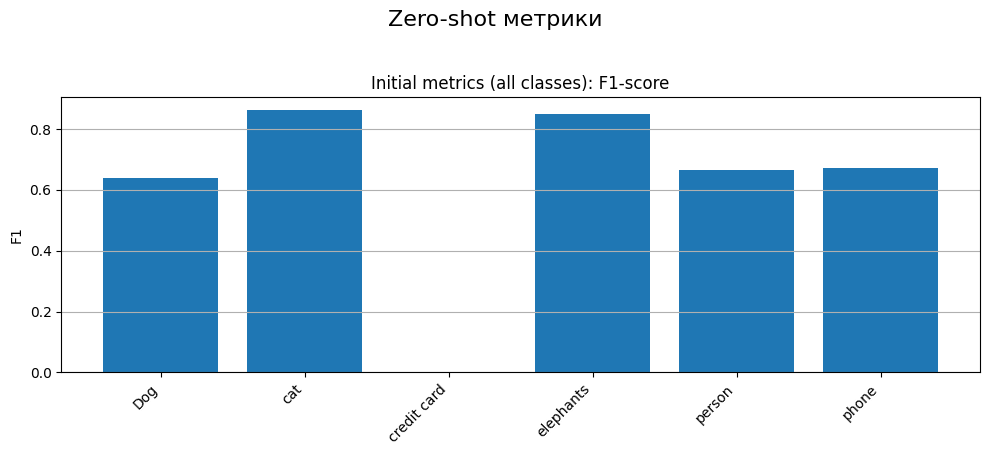

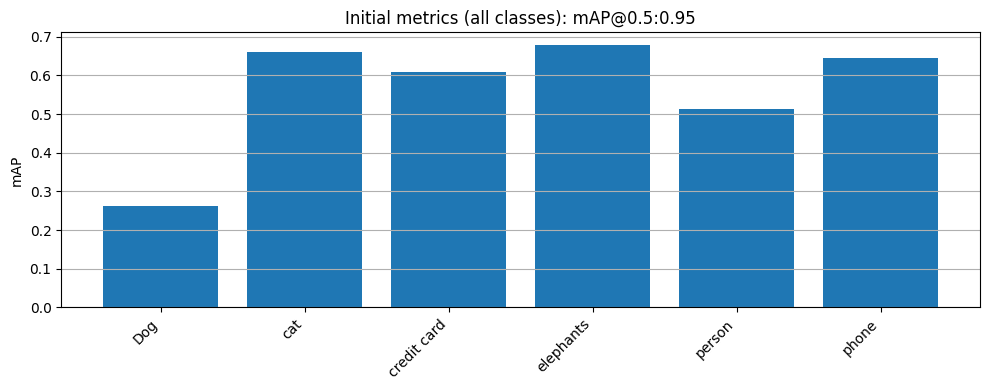

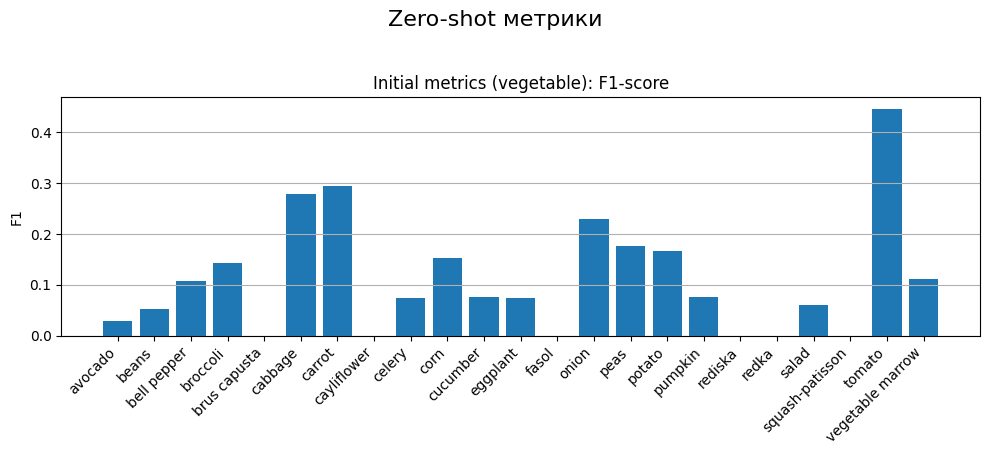

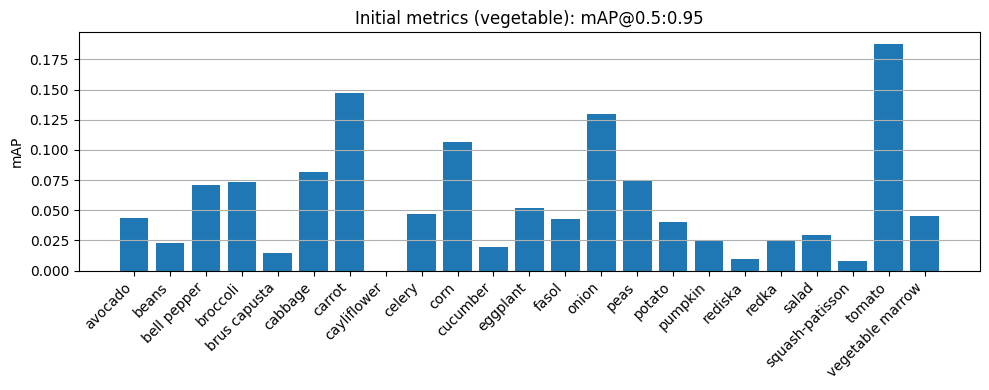

In [ ]:
plot_f1_and_map(initial_metrics, "Initial metrics (all classes)")
plot_f1_and_map(initial_veg_metrics, "Initial metrics (vegetable)")


In [ ]:
initial_metrics = load_metrics('initial_metrics.json')
best_both_metrics = load_metrics('best_both_data_metrics.json')

In [ ]:
init_classes = set(initial_metrics['per_class'].keys())
best_classes = set(best_both_metrics['per_class'].keys())

common_classes = sorted(init_classes & best_classes)
only_initial = sorted(init_classes - best_classes)
only_best = sorted(best_classes - init_classes)

print(f"Общие классы: {len(common_classes)}")
print(f"Только initial: {len(only_initial)}")
print(f"Только best_both: {len(only_best)}")


Общие классы: 6
Только initial: 0
Только best_both: 26


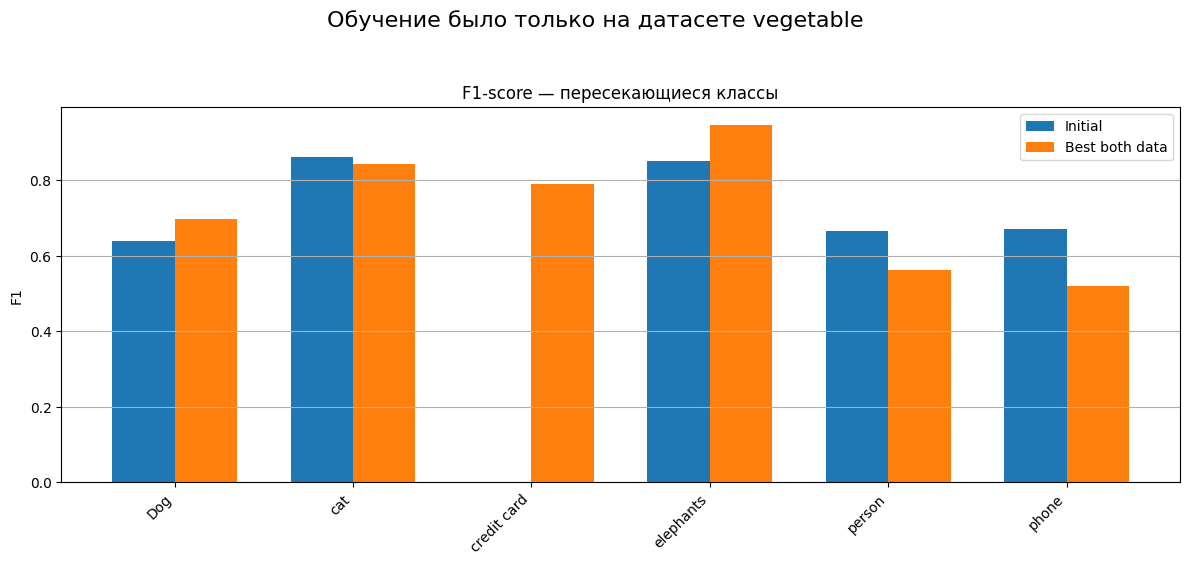

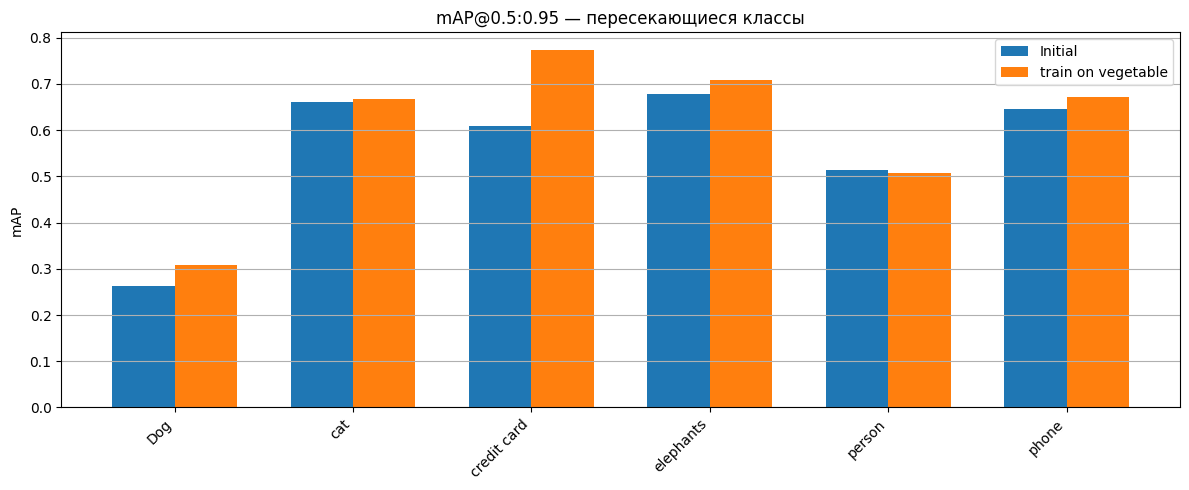

In [ ]:
x = np.arange(len(common_classes))
width = 0.35

f1_initial = [initial_metrics['per_class'][c]['f1'] for c in common_classes]
f1_best = [best_both_metrics['per_class'][c]['f1'] for c in common_classes]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, f1_initial, width, label='Initial')
plt.bar(x + width/2, f1_best, width, label='Best both data')

plt.title('F1-score — пересекающиеся классы')
plt.ylabel('F1')
plt.xticks(x, common_classes, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.figtext(0.5, 1.1, 'Обучение было только на датасете vegetable', ha='center', va='center', fontsize=16, color='black')
plt.show()

map_initial = [initial_metrics['per_class'][c]['ap50_95'] for c in common_classes]
map_best = [best_both_metrics['per_class'][c]['ap50_95'] for c in common_classes]

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, map_initial, width, label='Initial')
plt.bar(x + width/2, map_best, width, label='train on vegetable')

plt.title('mAP@0.5:0.95 — пересекающиеся классы')
plt.ylabel('mAP')
plt.xticks(x, common_classes, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

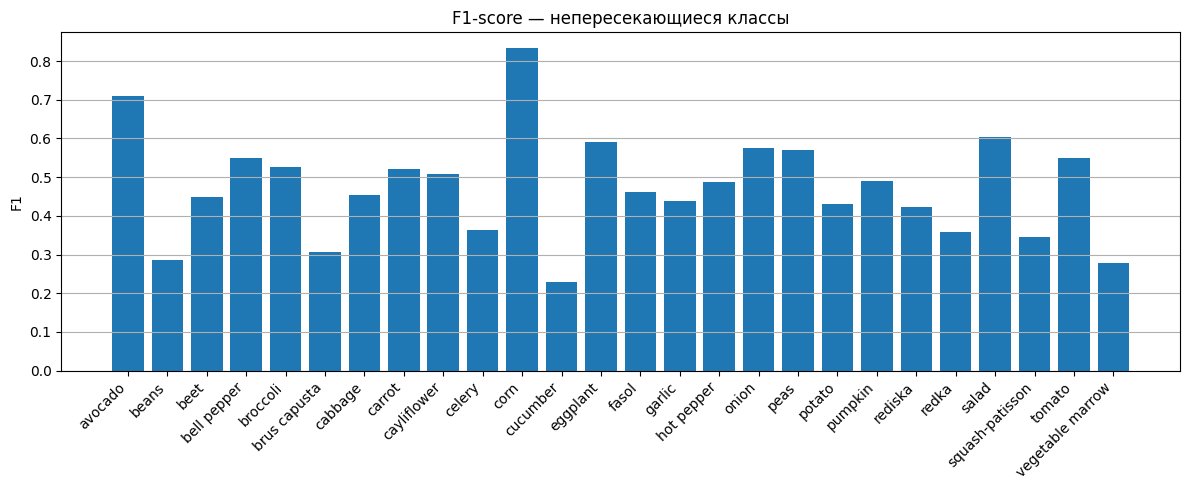

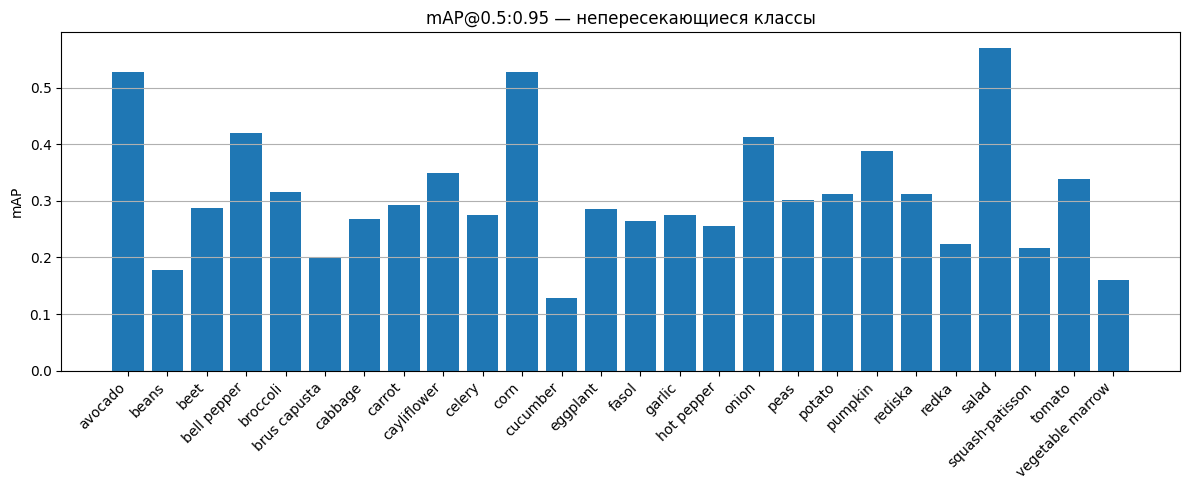

In [ ]:
non_common_classes = only_initial + only_best
f1_values = []

for c in non_common_classes:
    if c in initial_metrics['per_class']:
        f1_values.append(initial_metrics['per_class'][c]['f1'])
    else:
        f1_values.append(best_both_metrics['per_class'][c]['f1'])

plt.figure(figsize=(12, 5))
plt.bar(non_common_classes, f1_values)

plt.title('F1-score — непересекающиеся классы')
plt.ylabel('F1')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

map_values = []

for c in non_common_classes:
    if c in initial_metrics['per_class']:
        map_values.append(initial_metrics['per_class'][c]['ap50_95'])
    else:
        map_values.append(best_both_metrics['per_class'][c]['ap50_95'])

plt.figure(figsize=(12, 5))
plt.bar(non_common_classes, map_values)

plt.title('mAP@0.5:0.95 — непересекающиеся классы')
plt.ylabel('mAP')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# ================================
# 1️⃣ Google Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ================================
# 2️⃣ Imports
# ================================
import zipfile
from pathlib import Path
import json
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [ ]:
# ================================
# 3️⃣ Paths & Dataset
# ================================
ZIP_PATH = "/content/drive/MyDrive/term_work/random_dataset.v2i.coco.zip"
EXTRACT_PATH = "/content/random_dataset"
METRICS_SAVE_PATH = "/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics.json"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

dataset_path = Path(EXTRACT_PATH)
annotations_file = dataset_path / "valid" / "_annotations.coco.json"
images_dir = annotations_file.parent


In [ ]:
# ================================
# 4️⃣ COCO GT
# ================================
coco_gt = COCO(annotations_file)
images_info = {img["id"]: img for img in coco_gt.dataset["images"]}
categories = coco_gt.dataset["categories"]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# ================================
# 5️⃣ Grounding DINO
# ================================
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

GroundingDinoForObjectDetection(
  (model): GroundingDinoModel(
    (backbone): GroundingDinoConvModel(
      (conv_encoder): GroundingDinoConvEncoder(
        (model): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0): SwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=128, out_features=128, bias=True)
                        (key): Linear(in_featu

In [ ]:
# ================================
# 6️⃣ Zero-shot inference
# ================================
predictions = []

text_prompt = ". ".join([cat["name"] for cat in categories]) + "."

for img_id, img_info in images_info.items():
    img_path = images_dir / img_info["file_name"]
    image = Image.open(img_path).convert("RGB")

    inputs = processor(
        images=image,
        text=text_prompt,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        target_sizes=[image.size[::-1]]
    )[0]

    for score, box, text_label in zip(
        results["scores"], results["boxes"], results["text_labels"]
    ):
        try:
            category_id = next(
                cat["id"] for cat in categories if cat["name"] == text_label
            )
        except StopIteration:
            continue

        x_min, y_min, x_max, y_max = box.tolist()
        predictions.append({
            "image_id": img_id,
            "category_id": category_id,
            "bbox": [
                float(x_min),
                float(y_min),
                float(x_max - x_min),
                float(y_max - y_min)
            ],
            "score": float(score)
        })


In [ ]:
# ================================
# 7️⃣ COCO Evaluation
# ================================
coco_dt = coco_gt.loadRes(predictions)

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.558
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.729
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.571
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# ================================
# 8️⃣ Global metrics (CORRECT)
# ================================
global_metrics = {
    "precision@0.5": float(coco_eval.stats[1]),  # AP50
    "recall@0.5": float(coco_eval.stats[6]),     # AR50
    "mAP@0.5": float(coco_eval.stats[1]),
    "mAP@0.5:0.95": float(coco_eval.stats[0]),
}


In [ ]:
# ================================
# 9️⃣ Per-class mAP
# ================================
coco_eval_pc = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval_pc.evaluate()
coco_eval_pc.accumulate()

iou50_idx = np.where(coco_eval_pc.params.iouThrs == 0.5)[0][0]

per_class_metrics = {}

for cat_idx, cat in enumerate(categories):
    name = cat["name"]

    # AP@50
    p50 = coco_eval_pc.eval["precision"][iou50_idx, :, cat_idx, 0, -1]
    p50 = p50[p50 > -1]
    ap50 = float(np.mean(p50)) if p50.size > 0 else 0.0

    # AP@50:95
    pall = coco_eval_pc.eval["precision"][:, :, cat_idx, 0, -1]
    pall = pall[pall > -1]
    ap5095 = float(np.mean(pall)) if pall.size > 0 else 0.0

    per_class_metrics[name] = {
        "precision@0.5": ap50,
        "mAP@0.5": ap50,
        "mAP@0.5:0.95": ap5095
    }


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).


In [ ]:
# ================================
# 🔟 Save JSON to Drive
# ================================
metrics_json = {
    "model": model_id,
    "mode": "zero-shot",
    "dataset": "random_dataset.v2i.coco",
    "metrics": global_metrics,
    "per_class": per_class_metrics
}

with open(METRICS_SAVE_PATH, "w") as f:
    json.dump(metrics_json, f, indent=2)

print(f"✅ Метрики сохранены:\n{METRICS_SAVE_PATH}")


✅ Метрики сохранены:
/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics.json


#### для Vegetable

In [ ]:
# ================================
# 3️⃣ Paths & Dataset
# ================================
ZIP_PATH = "/content/drive/MyDrive/term_work/final_fruit_vegetable.v1i.coco.zip"
EXTRACT_PATH = "/content/random_dataset"
METRICS_SAVE_PATH = "/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics_vegetable.json"

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

dataset_path = Path(EXTRACT_PATH)
annotations_file = dataset_path / "valid" / "_annotations.coco.json"
images_dir = annotations_file.parent


In [ ]:
# ================================
# 4️⃣ COCO GT
# ================================
coco_gt = COCO(annotations_file)
images_info = {img["id"]: img for img in coco_gt.dataset["images"]}
categories = coco_gt.dataset["categories"]


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [ ]:
# ================================
# 5️⃣ Grounding DINO
# ================================
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
model.eval()


GroundingDinoForObjectDetection(
  (model): GroundingDinoModel(
    (backbone): GroundingDinoConvModel(
      (conv_encoder): GroundingDinoConvEncoder(
        (model): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0): SwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=128, out_features=128, bias=True)
                        (key): Linear(in_featu

In [ ]:
# ================================
# 6️⃣ Zero-shot inference
# ================================
predictions = []

text_prompt = ". ".join([cat["name"] for cat in categories]) + "."

for img_id, img_info in images_info.items():
    img_path = images_dir / img_info["file_name"]
    image = Image.open(img_path).convert("RGB")

    inputs = processor(
        images=image,
        text=text_prompt,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        target_sizes=[image.size[::-1]]
    )[0]

    for score, box, text_label in zip(
        results["scores"], results["boxes"], results["text_labels"]
    ):
        try:
            category_id = next(
                cat["id"] for cat in categories if cat["name"] == text_label
            )
        except StopIteration:
            continue

        x_min, y_min, x_max, y_max = box.tolist()
        predictions.append({
            "image_id": img_id,
            "category_id": category_id,
            "bbox": [
                float(x_min),
                float(y_min),
                float(x_max - x_min),
                float(y_max - y_min)
            ],
            "score": float(score)
        })


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (153225000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
# ================================
# 7️⃣ COCO Evaluation
# ================================
coco_dt = coco_gt.loadRes(predictions)

coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.98s).
Accumulating evaluation results...
DONE (t=0.60s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [ ]:
# ================================
# 8️⃣ Global metrics (CORRECT)
# ================================
global_metrics = {
    "precision@0.5": float(coco_eval.stats[1]),  # AP50
    "recall@0.5": float(coco_eval.stats[6]),     # AR50
    "mAP@0.5": float(coco_eval.stats[1]),
    "mAP@0.5:0.95": float(coco_eval.stats[0]),
}


In [ ]:
# ================================
# 9️⃣ Per-class mAP
# ================================
coco_eval_pc = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval_pc.evaluate()
coco_eval_pc.accumulate()

iou50_idx = np.where(coco_eval_pc.params.iouThrs == 0.5)[0][0]

per_class_metrics = {}

for cat_idx, cat in enumerate(categories):
    name = cat["name"]

    # AP@50
    p50 = coco_eval_pc.eval["precision"][iou50_idx, :, cat_idx, 0, -1]
    p50 = p50[p50 > -1]
    ap50 = float(np.mean(p50)) if p50.size > 0 else 0.0

    # AP@50:95
    pall = coco_eval_pc.eval["precision"][:, :, cat_idx, 0, -1]
    pall = pall[pall > -1]
    ap5095 = float(np.mean(pall)) if pall.size > 0 else 0.0

    per_class_metrics[name] = {
        "precision@0.5": ap50,
        "mAP@0.5": ap50,
        "mAP@0.5:0.95": ap5095
    }


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.23s).
Accumulating evaluation results...
DONE (t=0.61s).


In [ ]:
# ================================
# 🔟 Save JSON to Drive
# ================================
metrics_json = {
    "model": model_id,
    "mode": "zero-shot",
    "dataset": "final_fruit_vegetable.v1i.coco",
    "metrics": global_metrics,
    "per_class": per_class_metrics
}

with open(METRICS_SAVE_PATH, "w") as f:
    json.dump(metrics_json, f, indent=2)

print(f"✅ Метрики сохранены:\n{METRICS_SAVE_PATH}")


✅ Метрики сохранены:
/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics_vegetable.json


Common classes: ['cat', 'credit card', 'dogs', 'elephants', 'person', 'phone']


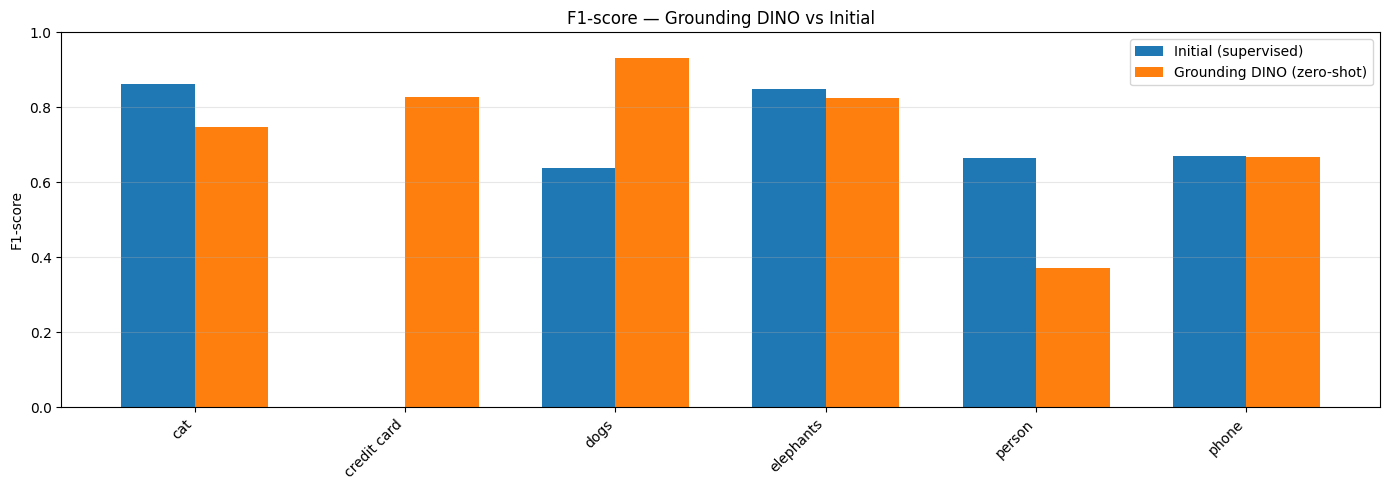

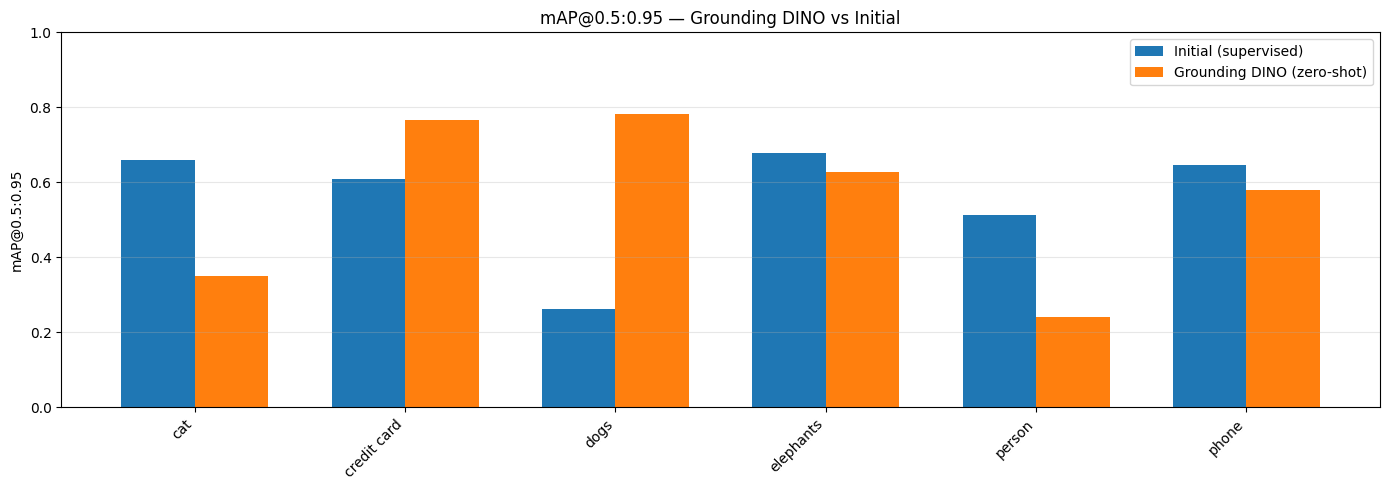

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Загрузка файлов
with open("/content/drive/MyDrive/term_work/metrics/initial_metrics.json") as f:
    initial_metrics = json.load(f)

# Standardize 'Dog' to 'dogs' in initial_metrics
if 'Dog' in initial_metrics['per_class']:
    initial_metrics['per_class']['dogs'] = initial_metrics['per_class'].pop('Dog')

with open("/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics.json") as f:
    dino_metrics = json.load(f)

# 🔹 Нормализация имён классов
def normalize_class(name):
    return name.lower().strip()

# 🔹 Подготовка per-class словарей
init_pc = {normalize_class(k): v for k, v in initial_metrics["per_class"].items()}
dino_pc = {normalize_class(k): v for k, v in dino_metrics["per_class"].items()}

# 🔹 Убираем мусорные zero-shot классы (которые содержат несколько классов через '-')
dino_pc = {k: v for k, v in dino_pc.items() if not ("-" in k and v["mAP@0.5"] == 0.0)}

# 🔹 Пересечение классов
common_classes = sorted(set(init_pc) & set(dino_pc))
print("Common classes:", common_classes)

# 🔹 Унифицированный доступ к метрикам
def get_init_metric(cls, metric):
    m = init_pc[cls]
    if metric == "f1":
        return m["f1"]
    elif metric == "map50_95":
        return m["ap50_95"]
    raise ValueError(metric)

def get_dino_metric(cls, metric):
    m = dino_pc[cls]
    if metric == "f1":
        # Вычисляем F1 через precision и recall, если они есть
        p = m.get("precision@0.5", None)
        r = m.get("mAP@0.5", None)  # приближение: используем AP как recall
        if p is not None and r is not None:
            return 2 * p * r / (p + r + 1e-6)
        else:
            return 0.0
    elif metric == "map50_95":
        return m["mAP@0.5:0.95"]
    raise ValueError(metric)

# 🔹 Фильтруем классы, где нет данных
def filter_valid_classes(metric):
    valid = []
    for c in common_classes:
        v1 = get_init_metric(c, metric)
        v2 = get_dino_metric(c, metric)
        if v1 is not None and v2 is not None:
            valid.append(c)
    return valid

# 🔹 Функция построения графика
def plot_comparison(metric, title, ylabel):
    valid_classes = filter_valid_classes(metric)
    init_vals = [get_init_metric(c, metric) for c in valid_classes]
    dino_vals = [get_dino_metric(c, metric) for c in valid_classes]

    x = np.arange(len(valid_classes))
    width = 0.35

    plt.figure(figsize=(14, 5))
    plt.bar(x - width/2, init_vals, width, label="Initial (supervised)")
    plt.bar(x + width/2, dino_vals, width, label="Grounding DINO (zero-shot)")

    plt.xticks(x, valid_classes, rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔹 Строим график F1-score
plot_comparison(
    metric="f1",
    title="F1-score — Grounding DINO vs Initial",
    ylabel="F1-score"
)

plot_comparison(
    metric="map50_95",
    title="mAP@0.5:0.95 — Grounding DINO vs Initial",
    ylabel="mAP@0.5:0.95"
)


Common classes (vegetable): ['avocado', 'beans', 'beet', 'bell pepper', 'broccoli', 'cabbage', 'carrot', 'cayliflower', 'corn', 'cucumber', 'eggplant', 'garlic', 'hot pepper', 'onion', 'peas', 'potato', 'pumpkin', 'rediska', 'salad', 'tomato']


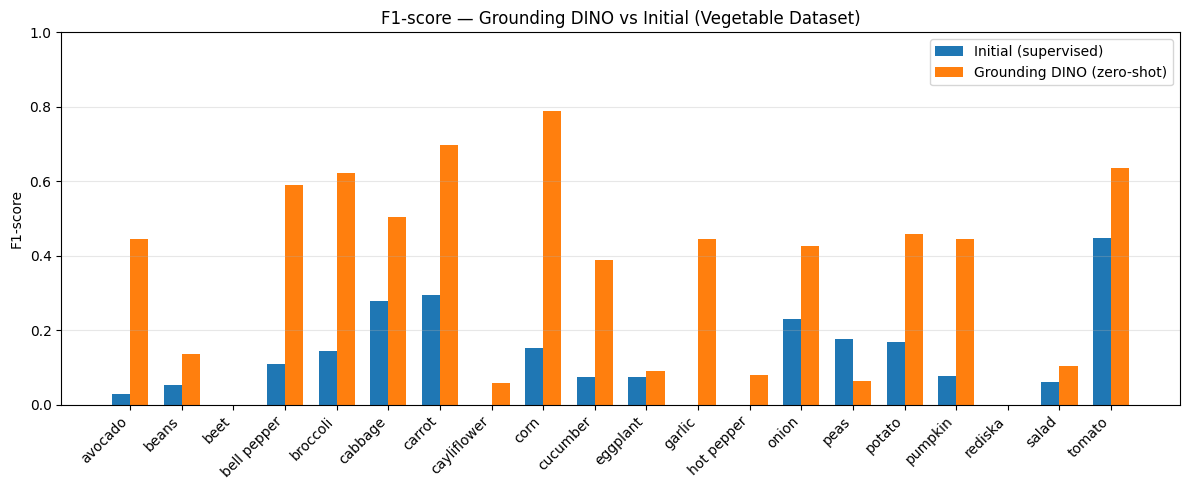

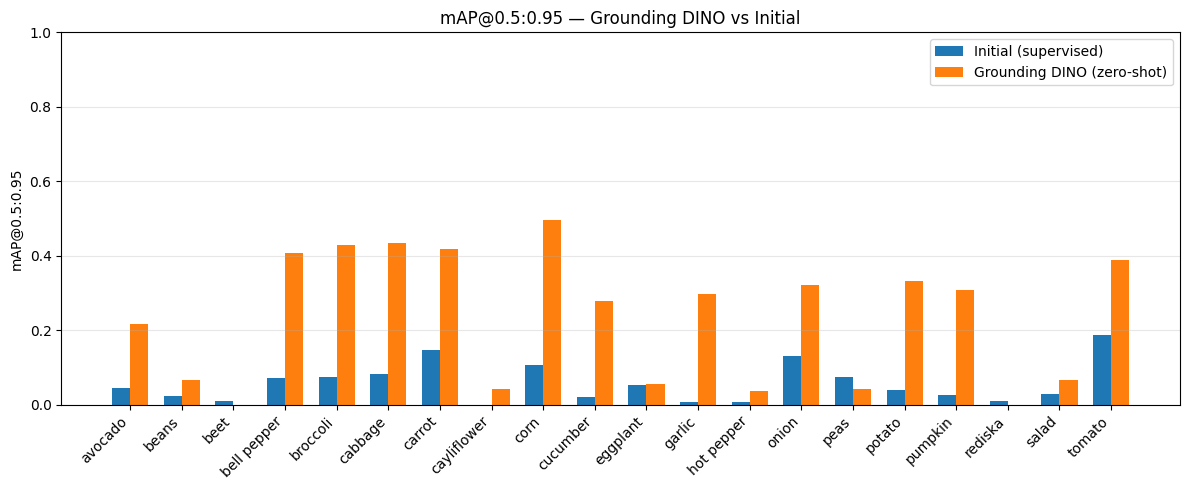

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Загрузка файлов для vegetable
with open("/content/drive/MyDrive/term_work/metrics/initial_metrics_on_vegetable.json") as f:
    initial_metrics_veg = json.load(f)

with open("/content/drive/MyDrive/term_work/metrics/grounding_dino_zero_shot_metrics_vegetable.json") as f:
    dino_metrics_veg = json.load(f)

# 🔹 Нормализация имён классов
def normalize_class(name):
    return name.lower().strip()

# 🔹 Подготовка per-class словарей
init_pc = {normalize_class(k): v for k, v in initial_metrics_veg["per_class"].items()}
dino_pc = {normalize_class(k): v for k, v in dino_metrics_veg["per_class"].items()}

# 🔹 Убираем мусорные zero-shot классы (например, объединённые через '-')
dino_pc = {k: v for k, v in dino_pc.items() if not ("-" in k and v.get("mAP@0.5", 0.0) == 0.0)}

# 🔹 Пересечение классов
common_classes = sorted(set(init_pc) & set(dino_pc))
print("Common classes (vegetable):", common_classes)

# 🔹 Унифицированный доступ к метрикам
def get_init_metric(cls, metric):
    m = init_pc[cls]
    if metric == "f1":
        return m["f1"]
    elif metric == "map50_95": # Added handling for map50_95
        return m["ap50_95"]
    raise ValueError(metric)

def get_dino_metric(cls, metric):
    m = dino_pc[cls]
    if metric == "f1":
        # вычисляем F1 через precision и AP как recall
        p = m.get("precision@0.5", None)
        r = m.get("mAP@0.5", None)  # приближение recall
        if p is not None and r is not None:
            return 2 * p * r / (p + r + 1e-6)
        else:
            return 0.0 # Return 0.0 if not calculable
    elif metric == "map50_95": # Added handling for map50_95
        return m["mAP@0.5:0.95"]
    raise ValueError(metric)

# 🔹 Фильтруем классы, где нет данных
def filter_valid_classes(metric):
    valid = []
    for c in common_classes:
        v1 = get_init_metric(c, metric)
        v2 = get_dino_metric(c, metric)
        if v1 is not None and v2 is not None: # Check against None as get_metric might return None if not handled
            valid.append(c)
    return valid

# 🔹 Функция построения графика
def plot_comparison(metric, title, ylabel):
    valid_classes = filter_valid_classes(metric)
    init_vals = [get_init_metric(c, metric) for c in valid_classes]
    dino_vals = [get_dino_metric(c, metric) for c in valid_classes]

    x = np.arange(len(valid_classes))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, init_vals, width, label="Initial (supervised)")
    plt.bar(x + width/2, dino_vals, width, label="Grounding DINO (zero-shot)")

    plt.xticks(x, valid_classes, rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔹 Построение графика F1-score для vegetable
plot_comparison(
    metric="f1",
    title="F1-score — Grounding DINO vs Initial (Vegetable Dataset)",
    ylabel="F1-score"
)

plot_comparison(
    metric="map50_95",
    title="mAP@0.5:0.95 — Grounding DINO vs Initial",
    ylabel="mAP@0.5:0.95"
)

Common classes: ['avocado', 'beans', 'beet', 'bell pepper', 'broccoli', 'cabbage', 'carrot', 'cat', 'cayliflower', 'corn', 'credit card', 'cucumber', 'dog', 'eggplant', 'elephants', 'garlic', 'hot pepper', 'onion', 'peas', 'potato', 'pumpkin', 'rediska', 'salad', 'squash-patisson', 'tomato']


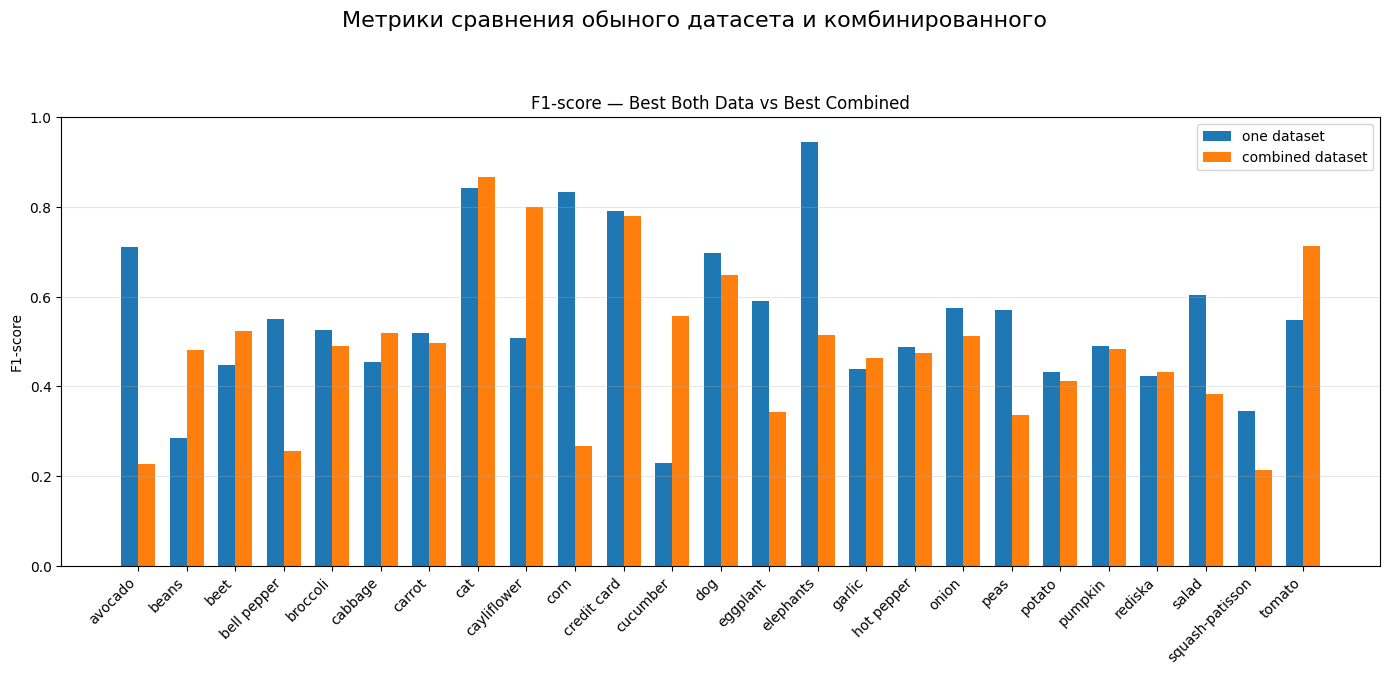

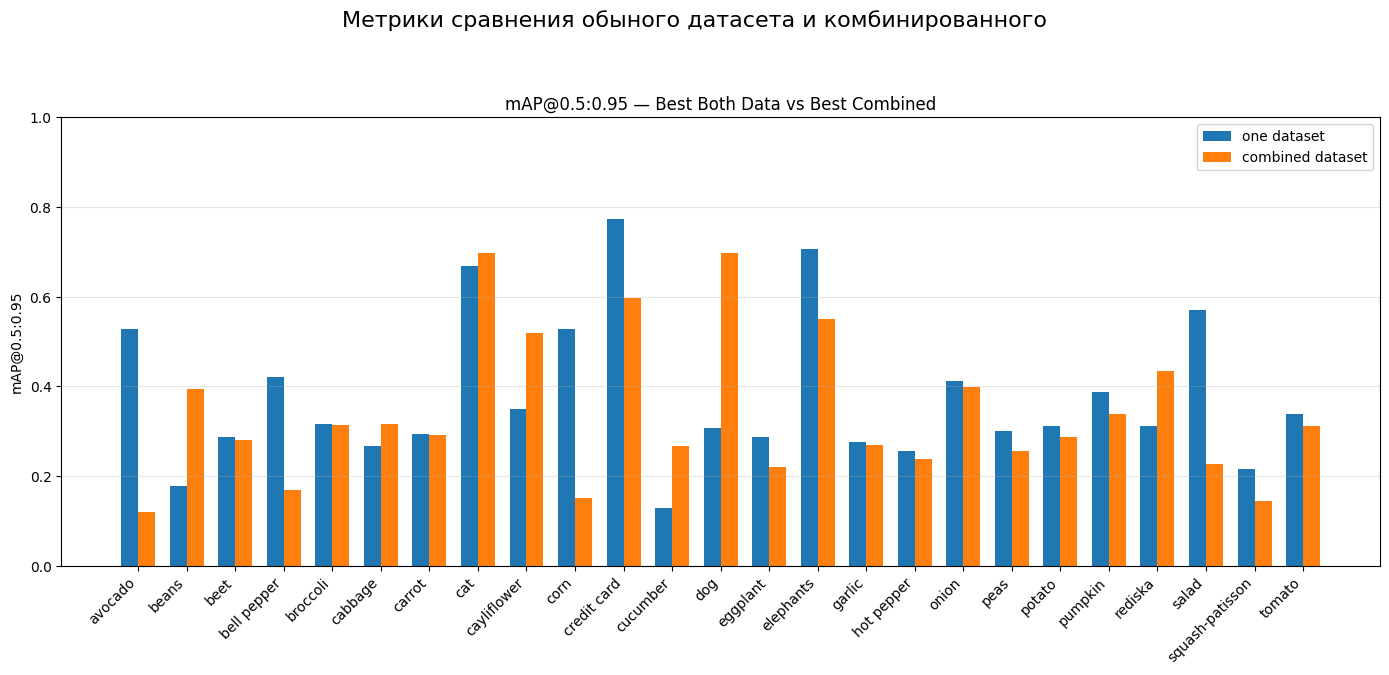

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Загрузка файлов из Google Drive
with open("/content/drive/MyDrive/term_work/metrics/best_both_data_metrics.json") as f:
    both_metrics = json.load(f)

with open("/content/drive/MyDrive/term_work/metrics/best_combined_metrics.json") as f:
    combined_metrics = json.load(f)

# 🔹 Нормализация имён классов
def normalize_class(name):
    return name.lower().strip()

# 🔹 Подготовка per-class словарей
both_pc = {normalize_class(k): v for k, v in both_metrics["per_class"].items()}
combined_pc = {normalize_class(k): v for k, v in combined_metrics["per_class"].items()}

# 🔹 Пересечение классов
common_classes = sorted(set(both_pc) & set(combined_pc))
print("Common classes:", common_classes)

# 🔹 Унифицированный доступ к метрикам
def get_metric(pc_dict, cls, metric):
    m = pc_dict[cls]
    if metric == "f1":
        return m["f1"]
    elif metric == "map50_95":
        return m["ap50_95"]
    else:
        raise ValueError(metric)

# 🔹 Фильтруем классы, где есть данные
def filter_valid_classes(metric):
    valid = []
    for c in common_classes:
        v1 = get_metric(both_pc, c, metric)
        v2 = get_metric(combined_pc, c, metric)
        if v1 is not None and v2 is not None:
            valid.append(c)
    return valid

# 🔹 Функция построения графика
def plot_comparison(metric, title, ylabel):
    valid_classes = filter_valid_classes(metric)
    both_vals = [get_metric(both_pc, c, metric) for c in valid_classes]
    combined_vals = [get_metric(combined_pc, c, metric) for c in valid_classes]

    x = np.arange(len(valid_classes))
    width = 0.35

    plt.figure(figsize=(14, 6))
    plt.bar(x - width/2, both_vals, width, label="one dataset")
    plt.bar(x + width/2, combined_vals, width, label="combined dataset")

    plt.xticks(x, valid_classes, rotation=45, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1)
    plt.grid(axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.figtext(0.5, 1.1, 'Метрики сравнения обыного датасета и комбинированного', ha='center', va='center', fontsize=16, color='black')
    plt.show()

# 🔹 Построение графиков
plot_comparison(
    metric="f1",
    title="F1-score — Best Both Data vs Best Combined",
    ylabel="F1-score"
)

plot_comparison(
    metric="map50_95",
    title="mAP@0.5:0.95 — Best Both Data vs Best Combined",
    ylabel="mAP@0.5:0.95"
)
